In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import cm
from PIL import Image
import matplotlib.image as mpimg
import copy
import matplotlib as mpl

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.weight"] = "bold"

plt.rcParams["font.size"] = "12"
matplotlib.font_manager._rebuild()

%matplotlib inline

In [2]:
vizwiz_train = pd.read_csv('../../data/three_vote_threshold_old/vizwiz_skill_typ_train.csv', skipinitialspace=True, engine='python')
vizwiz_val = pd.read_csv('../../data/three_vote_threshold_old/vizwiz_skill_typ_val.csv', skipinitialspace=True, engine='python')
vizwiz_test = pd.read_csv('../../data/three_vote_threshold_old/vizwiz_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train = pd.read_csv('../../data/three_vote_threshold_old/vqa_skill_typ_train.csv', skipinitialspace=True, engine='python')
vqa_val = pd.read_csv('../../data/three_vote_threshold_old/vqa_skill_typ_val.csv', skipinitialspace=True, engine='python')
vqa_test = pd.read_csv('../../data/three_vote_threshold_old/vqa_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train['QID'] = vqa_train['QID'].astype(str)
vqa_val['QID'] = vqa_val['QID'].astype(str)
vqa_test['QID'] = vqa_test['QID'].astype(str)

vizwiz = pd.concat([vizwiz_train, vizwiz_val, vizwiz_test])
vqa = pd.concat([vqa_train, vqa_val, vqa_test])
df = pd.concat([vizwiz, vqa])

# vizwiz = vizwiz[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]
# vqa = vqa[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]

# all crowdsourced data
# df = pd.read_csv('../../data/VizWiz_VQA_Skills_Data.csv', engine='python')

In [9]:
vqa_train['IMG'].nunique() + vqa_val['IMG'].nunique() + vqa_test['IMG'].nunique()

4758

In [32]:
vizwiz['col_keyword'] = vizwiz['QSN'].apply(lambda x: 1 if 'color' in x else 0)
vqa['col_keyword'] = vqa['QSN'].apply(lambda x: 1 if 'color' in x else 0)

vizwiz['COL_flag'] = vizwiz['COL'].apply(lambda x: 1 if x >= 3 else 0)
vizwiz['CNT_flag'] = vizwiz['CNT'].apply(lambda x: 1 if x >= 3 else 0)
vqa['COL_flag'] = vqa['COL'].apply(lambda x: 1 if x >= 3 else 0)
vqa['CNT_flag'] = vqa['CNT'].apply(lambda x: 1 if x >= 3 else 0)

In [33]:
vizwiz['col_keyword'].corr(vizwiz['COL_flag'])

0.7485217414807647

In [35]:
pearsonr(vqa['col_keyword'],vqa['COL_flag'])

(0.5929116104576178, 0.0)

In [27]:
vizwiz['cnt_keyword'] = vizwiz['QSN'].apply(lambda x: 1 if 'many' in x or 'much' in x else 0)
vqa['cnt_keyword'] = vqa['QSN'].apply(lambda x: 1 if 'many' in x or 'much' in x else 0)

In [37]:
pearsonr(vizwiz['cnt_keyword'],vizwiz['CNT_flag'])

(0.3185158800128906, 0.0)

In [10]:
len(df)  # 3 rows not in previous train/test/splits are ignored

27260

In [11]:
df['QID'].nunique()

27260

In [6]:
df['SRC_DATASET'].unique()

array(['VizWiz', 'VQA'], dtype=object)

#### figure 2, dist of skill combinations

In [286]:
# none of the above - no agreed skill label
dset = vqa
(len(dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)]) / len(dset) ) # * 100

0.00834326579261025

In [4]:
# percentage of QA with a single skill
dset = vizwiz

obj = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
col = (dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] >= 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
txt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] >= 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
cnt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] >= 3)
           & (dset['OTH'] < 3)])
oth = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] >= 3)])

(len(obj) + len(col) + len(txt) + len(cnt) + len(oth)) / len(dset)

0.7619454692702241

In [224]:
len(col)

632

In [225]:
len(one_skill(vizwiz, 'COL', ratio=False))

632

In [3]:
# convert skills labels into binary based on 3-vote threshold
def convert_binary_labels(df):
    df['col'] = ""
    df['txt'] = ""
    df['cnt'] = ""
    for i, row in df.iterrows():
        if row['COL'] >= 3:
            row[-3] = 1
        if row['TXT'] >= 3:
            row[-2] = 1
        if row['CNT'] >= 3:
            row[-1] = 1
    return df

In [5]:
vizwiz = convert_binary_labels(df)
vqa = convert_binary_labels(vqa)

In [4]:
def one_skill(dset, s, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s]))
    df = (dset.loc[(dset[s] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3)
                   & (dset[mute[2]] < 3) 
                   & (dset[mute[3]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s}: {r}')
        return r
    else: return df
    
def one_skill_nonexclusive(dset, s, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    df = dset.loc[(dset[s] >= 3)]
    if ratio:
        r = len(df)/len(dset)
        print(f'{s}: {r}')
        return r
    else: return df

    
def two_skills(dset, s1, s2, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3) 
                   & (dset[mute[2]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2}: {r}')
        return r
    else: return df
    
def two_skill_nonexclusive(dset, s1, s2, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    df = dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3)]
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2}: {r}')
        return r
    else: return df

def three_skills(dset, s1, s2, s3, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3)
                   & (dset[mute[0]] < 3)
                   & (dset[mute[1]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3}: {r}')
        return r
    else: return df

def four_skills(dset, s1, s2, s3, s4, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3,s4]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3) & (dset[s4] >= 3)
                   & (dset[mute[0]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3} & {s4}: {r}')
        return r
    else: return df

In [229]:
# ratio of 1 skill only
dset = vqa
(len(one_skill(dset, 'OBJ', False)) + 
len(one_skill(dset, 'COL', False)) + 
len(one_skill(dset, 'TXT', False)) + 
len(one_skill(dset, 'CNT', False)) + 
len(one_skill(dset, 'OTH', False)) ) / len(dset)

0.6313071116408423

In [230]:
# single skill dist
dset = vqa
for s in skills: 
    one_skill(dset, s)

OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0


In [231]:
dset = vqa

# two skills (5 choose 2) ratios
two_skills(dset, 'OBJ', 'COL')
two_skills(dset, 'OBJ', 'TXT')
two_skills(dset, 'OBJ', 'CNT')
two_skills(dset, 'OBJ', 'OTH')
two_skills(dset, 'COL', 'TXT')
two_skills(dset, 'COL', 'CNT')
two_skills(dset, 'COL', 'OTH')
two_skills(dset, 'TXT', 'CNT')
two_skills(dset, 'TXT', 'OTH')
two_skills(dset, 'CNT', 'OTH')

OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0.0


0.0

In [35]:
# ratio of 2 skills
dset = vizwiz
(
len(two_skills(dset, 'OBJ', 'COL', False)) + 
len(two_skills(dset, 'OBJ', 'TXT', False)) + 
len(two_skills(dset, 'OBJ', 'CNT', False)) + 
len(two_skills(dset, 'OBJ', 'OTH', False)) + 
len(two_skills(dset, 'COL', 'TXT', False)) + 
len(two_skills(dset, 'COL', 'CNT', False)) + 
len(two_skills(dset, 'COL', 'OTH', False)) + 
len(two_skills(dset, 'TXT', 'CNT', False)) + 
len(two_skills(dset, 'TXT', 'OTH', False)) +
len(two_skills(dset, 'CNT', 'OTH', False)) ) / len(dset)

0.5934041212993791

In [45]:
# ratio of 3 skills
dset = vqa
( 
len(three_skills(dset, 'OBJ', 'COL', 'TXT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'TXT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'TXT', 'CNT', 'OTH', False)) ) / len(dset)

0.025029797377830752

In [57]:
# three skill combinations
dset = vqa

three_skills(dset, 'OBJ', 'TXT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'TXT')
three_skills(dset, 'OBJ', 'TXT', 'CNT')
three_skills(dset, 'OBJ', 'CNT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'OTH')
three_skills(dset, 'COL', 'TXT', 'CNT')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'TXT', 'CNT', 'OTH')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'COL', 'TXT', 'OTH')

OBJ & TXT & OTH: 0.0
OBJ & COL & TXT: 0.0013905442987683751
OBJ & TXT & CNT: 0.007350019864918554
OBJ & CNT & OTH: 0.0
OBJ & COL & OTH: 0.0
COL & TXT & CNT: 0.0
COL & CNT & OTH: 0.0
TXT & CNT & OTH: 0.0
COL & CNT & OTH: 0.0
COL & TXT & OTH: 0.0


0.0

In [47]:
# ratio of four skills - 5 choose 4 = 5
dset = vizwiz
skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
(
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'CNT', False)) + 
len(four_skills(dset, 'OBJ', 'TXT', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'OBJ', 'COL', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'COL', 'TXT', 'CNT', 'OTH', False)) + 
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'OTH', False))
) / len(dset)

8.99847026005579e-05

OBJ: 0.9325114730495816
COL: 0.22064249077656797
TXT: 0.45329793935031043
CNT: 0.014892468280392333
OTH: 8.99847026005579e-05
OBJ: 0.9791418355184743
COL: 0.16686531585220502
TXT: 0.05701231624950338
CNT: 0.16567342073897498
OTH: 0.0009932459276916965


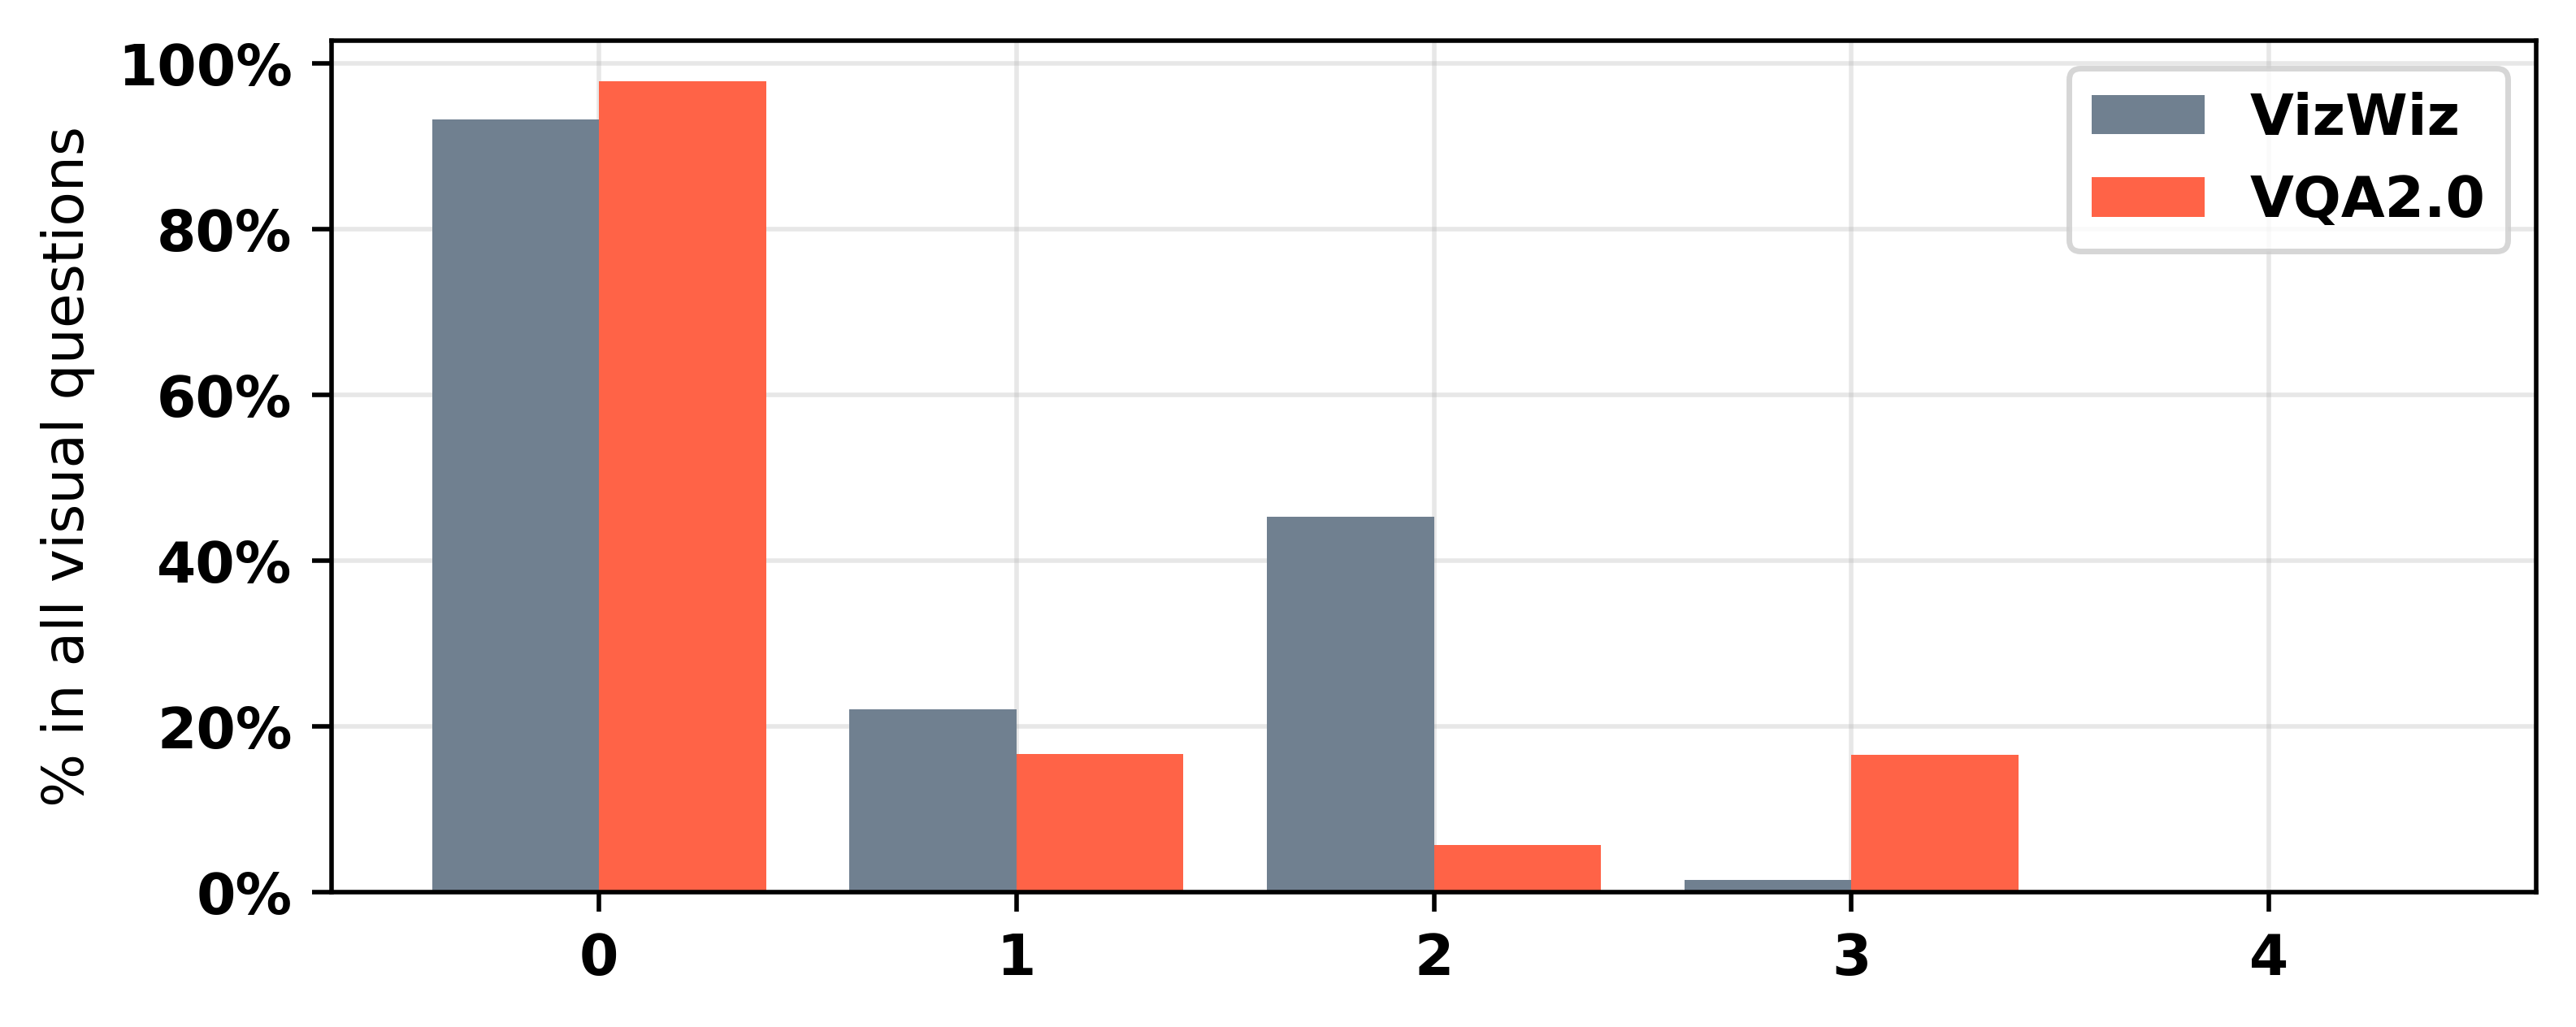

In [18]:
# one skill

fig = figure(num=None, figsize=(7, 10), dpi=500)
w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
_one_skill = np.arange(len(skills))
dset = vizwiz
vizwiz_data = [one_skill_nonexclusive(dset, 'OBJ'),
               one_skill_nonexclusive(dset, 'COL'), 
               one_skill_nonexclusive(dset, 'TXT'), 
               one_skill_nonexclusive(dset, 'CNT'),
               one_skill_nonexclusive(dset, 'OTH') ]
dset = vqa
vqa_data = [one_skill_nonexclusive(dset, 'OBJ'),
            one_skill_nonexclusive(dset, 'COL'), 
            one_skill_nonexclusive(dset, 'TXT'),
            one_skill_nonexclusive(dset, 'CNT'),
            one_skill_nonexclusive(dset, 'OTH') ]

one_skill_plot = fig.add_subplot(3,1,1, sharex=None, sharey=None)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
one_skill_plot.set_xticks(_one_skill)
#one_skill_plot.set_xticklabels(skills)
#one_skill_plot.set_xlabel('Skill')
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
# one_skill_plot.set_title('Distributions of skills')
one_skill_plot.legend()

# single skill
"""
single_skills = ['COL', 'TXT', 'CNT']
_single_skill = np.arange(len(single_skills))
dset = vizwiz
vizwiz_data = [0.4988161010260458, 0.49644830307813737, 0.004735595895816891]
vqa_data = [0.36666666666666664, 0.21666666666666665, 0.41666666666666663]
single_skill_plot = fig.add_subplot(3,1,2, sharex=None, sharey=None)
single_skill_plot.grid(alpha=.3)
single_skill_plot.set_axisbelow(True)
single_skill_plot.bar(_single_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
single_skill_plot.bar(_single_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
single_skill_plot.set_xticks(_single_skill)
single_skill_plot.set_xticklabels(single_skills)
single_skill_plot_y_ticks = single_skill_plot.get_yticks()
single_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in single_skill_plot_y_ticks])
single_skill_plot.legend()
#single_skill_plot.set_xlabel('Skill')
single_skill_plot.set_ylabel('% in single-skill visual questions')

# two skills
two_skill_combinations = ['OBJ & COL', 
                          'OBJ & TXT', 'OBJ & CNT', 
                          'COL & TXT', 'COL & CNT', 'TXT & CNT']
_two_skill = np.arange(len(two_skill_combinations))
dset = vizwiz
vizwiz_data = [two_skill_nonexclusive(dset, 'OBJ', 'TXT'),
               two_skill_nonexclusive(dset, 'OBJ', 'COL'), 
               two_skill_nonexclusive(dset, 'OBJ', 'CNT'),
               two_skill_nonexclusive(dset, 'COL', 'TXT'), 
               two_skill_nonexclusive(dset, 'TXT', 'CNT'),
               two_skill_nonexclusive(dset, 'COL', 'CNT')]
dset = vqa
vqa_data = [two_skill_nonexclusive(dset, 'OBJ', 'TXT'),
            two_skill_nonexclusive(dset, 'OBJ', 'COL'), 
            two_skill_nonexclusive(dset, 'OBJ', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'TXT'), 
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]
two_skill_plot = fig.add_subplot(3,1,2, sharex=None, sharey=None)
two_skill_plot.grid(alpha=.3)
two_skill_plot.set_axisbelow(True)
two_skill_plot.bar(_two_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
two_skill_plot.bar(_two_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
two_skill_plot.set_xticklabels(two_skill_combinations)
two_skill_plot.set_xticks(_two_skill)
two_skill_plot_y_ticks = two_skill_plot.get_yticks()
two_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in two_skill_plot_y_ticks])
# two_skill_plot.set_title('Combinations of skills')
two_skill_plot.legend()
#two_skill_plot.set_xlabel('Skill')
two_skill_plot.tick_params(axis='x', labelsize=10)
two_skill_plot.set_ylabel('% in all visual questions')
"""
plt.subplots_adjust(hspace=.3)
plt.show()

In [233]:
# approximately $5.7\%$ of VizWiz and $1.2\%$ of VQA required only one skill.
dset = vizwiz
vizwiz_single_skill = [one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]
print(np.sum(np.array(vizwiz_single_skill)))
dset = vqa
vqa_single_skill = [one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]
print(np.sum(np.array(vqa_single_skill)))

COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0
0.05700530909745343
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0
0.011918951132300359


In [80]:
# in single skill questions
dset = vizwiz
print('vizwiz, color in single skill questions: ', 0.028435166021776297 /  0.05700530909745343)
print('text in single skill questions:', 0.02830018896787546 / 0.05700530909745343)
print('counting in single skill questions:', 0.0002699541078016737 / 0.05700530909745343)

vizwiz, color in single skill questions:  0.4988161010260458
text in single skill questions: 0.49644830307813737
counting in single skill questions: 0.004735595895816891


In [81]:
dset = vqa 
print('vqa, color in single skill questions: ', 0.004370282081843465 / 0.011918951132300359)
print('text in single skill questions:', 0.002582439411998411 / 0.011918951132300359)
print('counting in single skill questions:', 0.004966229638458482 / 0.011918951132300359)

vqa, color in single skill questions:  0.36666666666666664
text in single skill questions: 0.21666666666666665
counting in single skill questions: 0.41666666666666663


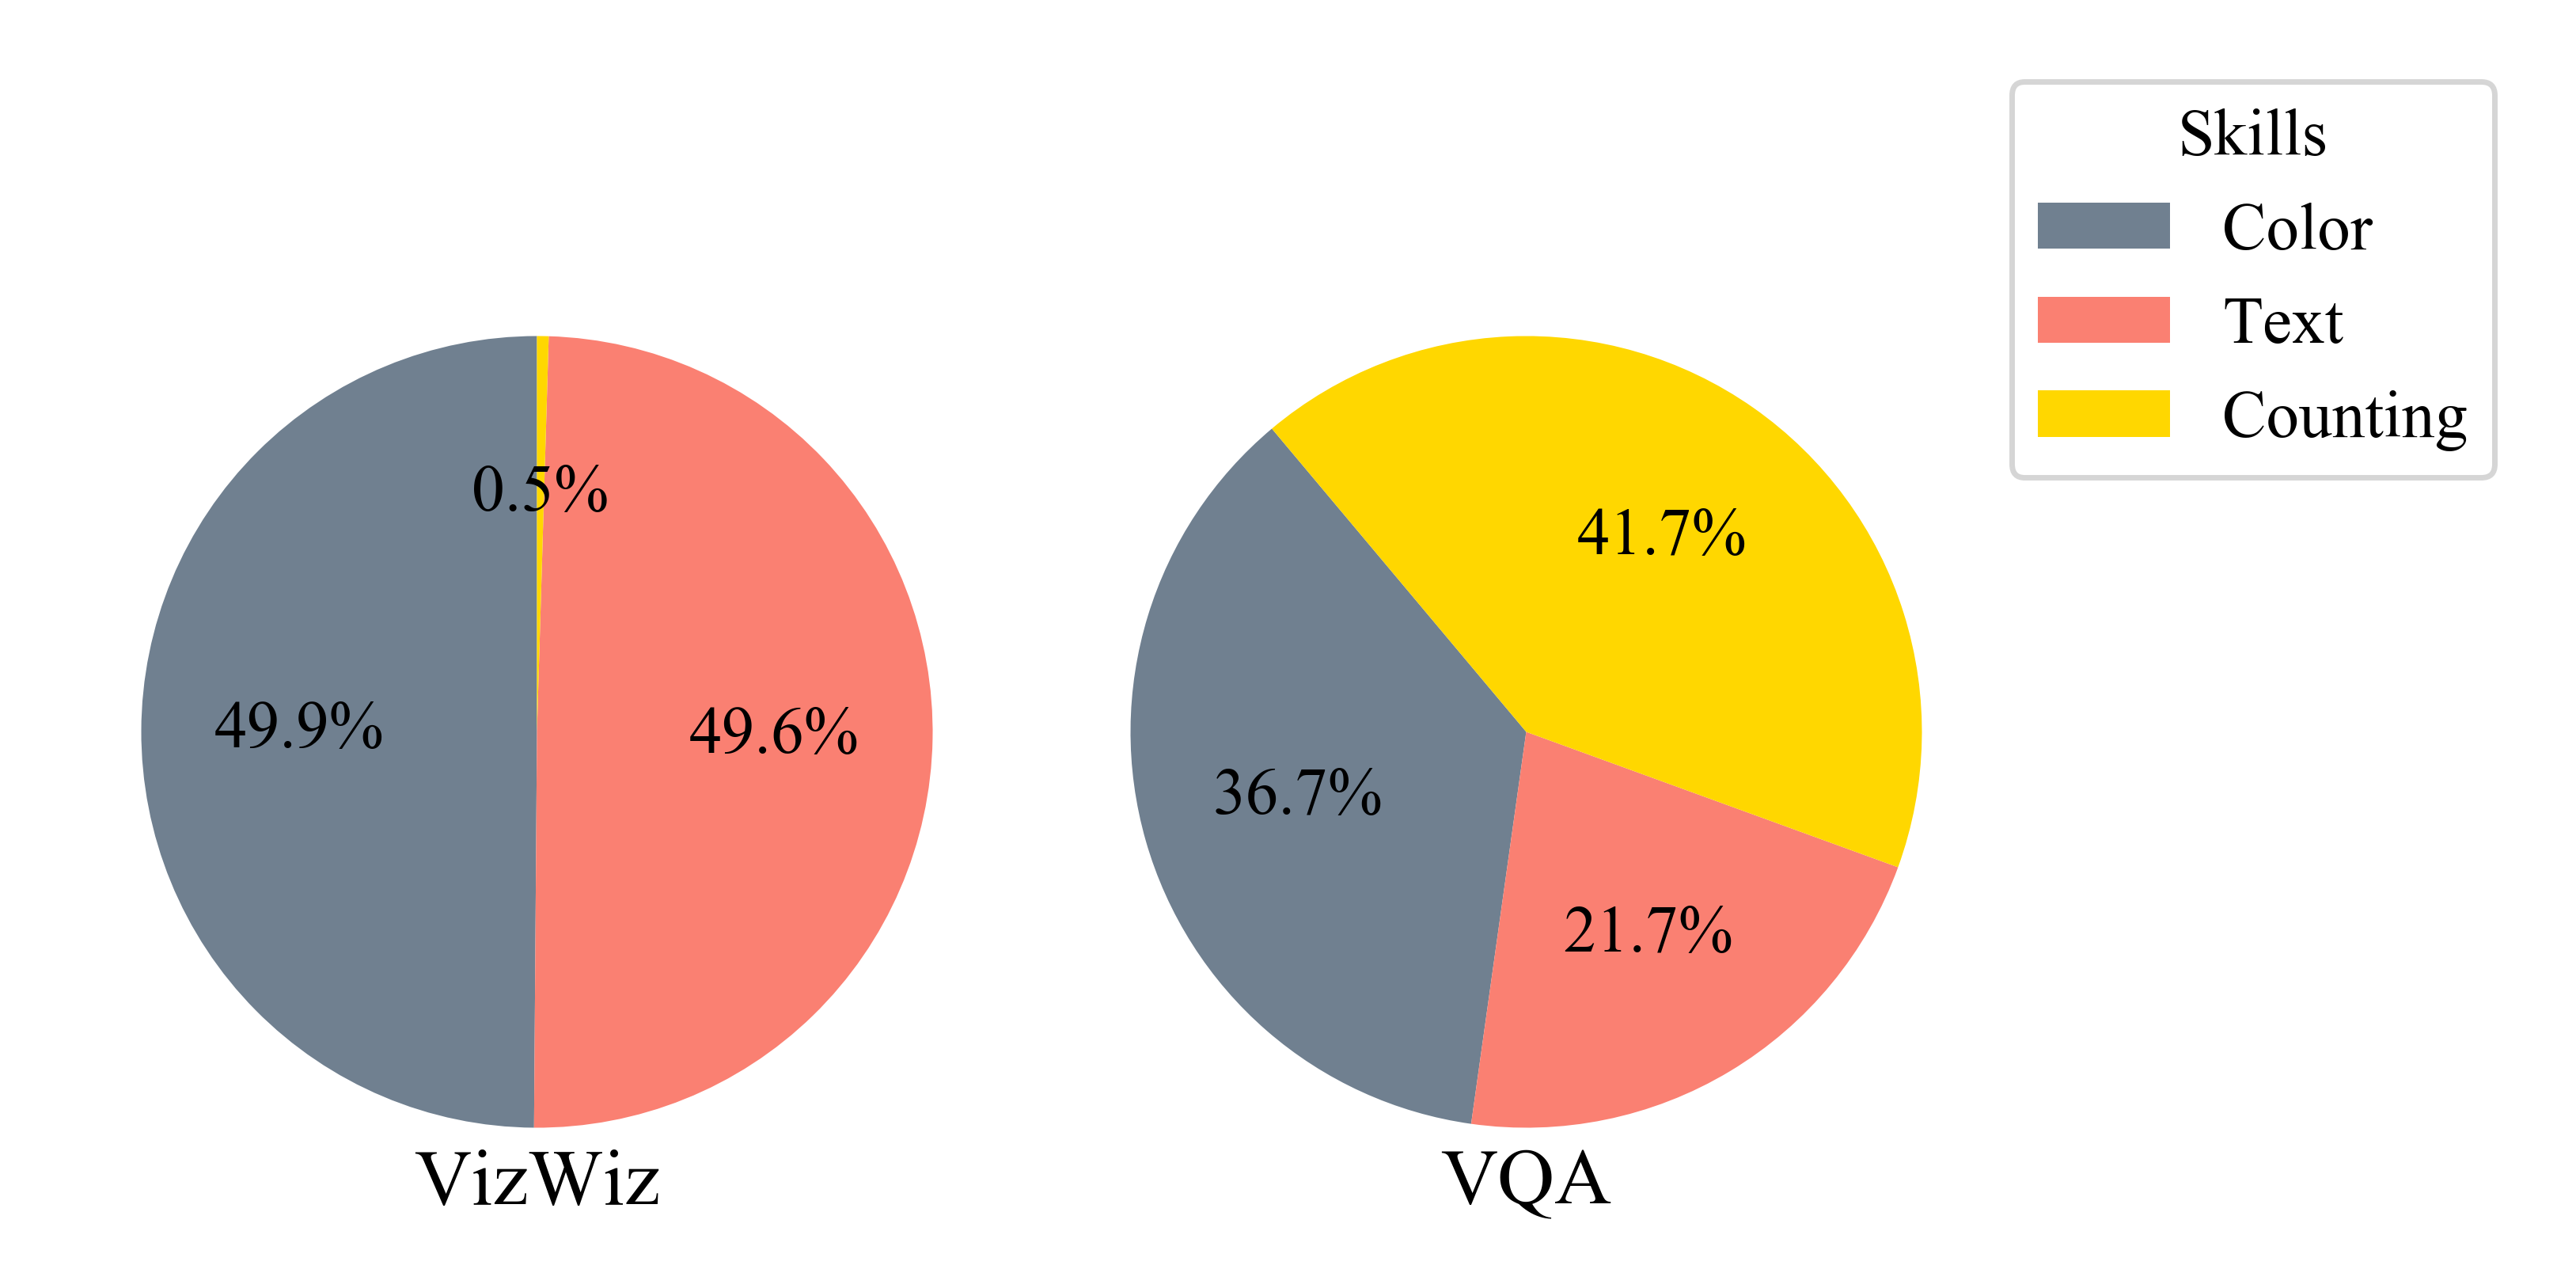

In [295]:
# pie charts of single skill distribution

labels = 'Color', 'Text', 'Counting'
vizwiz_sizes = [49.8816, 49.6448, 0.4736]
vqa_sizes = [36.6667, 21.6667, 41.6667]

fig = plt.figure(num=None, figsize=(5,5), dpi=500)

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(vizwiz_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=90, colors=['slategray', 'salmon', 'gold'])
ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(vqa_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=130, colors=['slategray', 'salmon', 'gold'])
ax1.set_title('VizWiz', y=-0.01)
ax2.set_title('VQA', y=-0.01)

fig.legend(wedges1, [x.split()[-1] for x in labels],
          title="Skills",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# plt.subplots_adjust(wspace=.9)
plt.show()

In [198]:
# ratio of multi skill questions 
dset = vizwiz
vizwiz_data = [two_skill_nonexclusive(dset, 'COL', 'TXT'),
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]
dset = vqa
vqa_data = [two_skill_nonexclusive(dset, 'COL', 'TXT'),
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]

COL & TXT: 0.01120309547376946
TXT & CNT: 0.008548546747053002
COL & CNT: 0.0004499235130027895
COL & TXT: 0.0013905442987683751
TXT & CNT: 0.0077473182359952325
COL & CNT: 0.009137862534763607


In [199]:
vizwiz.head(1)

,Unnamed: 0,QID,TXT,OBJ,COL,CNT,OTH,SRC_DATASET,ANS_TYP,IMG,...,ANS4,ANS5,ANS6,ANS7,ANS8,ANS9,ANS10,NUM_UNIQUE_ANS,NUM_MOST_COMMON_ANS,split
0,10756,VizWiz_train_000000000000.jpg,4,3,0,0,0,VizWiz,other,VizWiz_train_000000000000.jpg,...,basil,basil leaves,basil leaves,basil leaves,basil leaves,basil leaves,basil,2,7,train


In [245]:
vizwiz = vizwiz[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]
vqa = vqa[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]

vizwiz_txt = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['COL'] < 3) & (vizwiz['CNT'] < 3)]
vizwiz_col = vizwiz.loc[(vizwiz['COL'] >= 3) & (vizwiz['TXT'] < 3) & (vizwiz['CNT'] < 3)]
vizwiz_cnt = vizwiz.loc[(vizwiz['CNT'] >= 3) & (vizwiz['TXT'] < 3) & (vizwiz['COL'] < 3)]

len(vizwiz_txt)/len(vizwiz) + len(vizwiz_col)/len(vizwiz) + len(vizwiz_cnt)/len(vizwiz)

0.6486997210474219

In [247]:
vqa_txt = vqa.loc[(vqa['TXT'] >= 3) & (vqa['COL'] < 3) & (vqa['CNT'] < 3)]
vqa_col = vqa.loc[(vqa['COL'] >= 3) & (vqa['TXT'] < 3) & (vqa['CNT'] < 3)]
vqa_cnt = vqa.loc[(vqa['CNT'] >= 3) & (vqa['COL'] < 3) & (vqa['TXT'] < 3)]

len(vqa_txt)/len(vqa) + len(vqa_col)/len(vqa) + len(vqa_cnt)/len(vqa)

0.35299960270162895

In [7]:
vizwiz_txt_col = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['COL'] >= 3) & (vizwiz['CNT'] < 3)]
vizwiz_col_cnt = vizwiz.loc[(vizwiz['COL'] >= 3) & (vizwiz['CNT'] >= 3) & (vizwiz['TXT'] < 3)]
vizwiz_txt_cnt = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['CNT'] >= 3) & (vizwiz['COL'] < 3)]

vqa_txt_col = vqa.loc[(vqa['TXT'] >= 3) & (vqa['COL'] >= 3) & (vqa['CNT'] < 3)]
vqa_col_cnt = vqa.loc[(vqa['COL'] >= 3) & (vqa['CNT'] >= 3) & (vqa['TXT'] < 3)]
vqa_txt_cnt = vqa.loc[(vqa['TXT'] >= 3) & (vqa['CNT'] >= 3) & (vqa['COL'] < 3)]

In [19]:
def questions_with_two_skills(df):
    return df.loc[((df['COL'] >= 3) & (df['TXT'] >= 3) & (df['CNT'] < 3)) |
          ((df['CNT'] >= 3) & (df['TXT'] >= 3) & (df['COL'] < 3)) |
           ((df['CNT'] >= 3) & (df['COL'] >= 3) & (df['TXT'] < 3))
          ]

In [20]:
vizwiz_two_skills = questions_with_two_skills(vizwiz)
vqa_two_skills = questions_with_two_skills(vqa)
#vizwiz_two_skills = len(vizwiz_txt_col + vizwiz_col_cnt + vizwiz_txt_cnt)
#vqa_two_skills = len(vqa_txt_col + vqa_col_cnt + vqa_txt_cnt)
len(vizwiz_txt_col) / len(vizwiz_two_skills)

0.5575620767494357

2

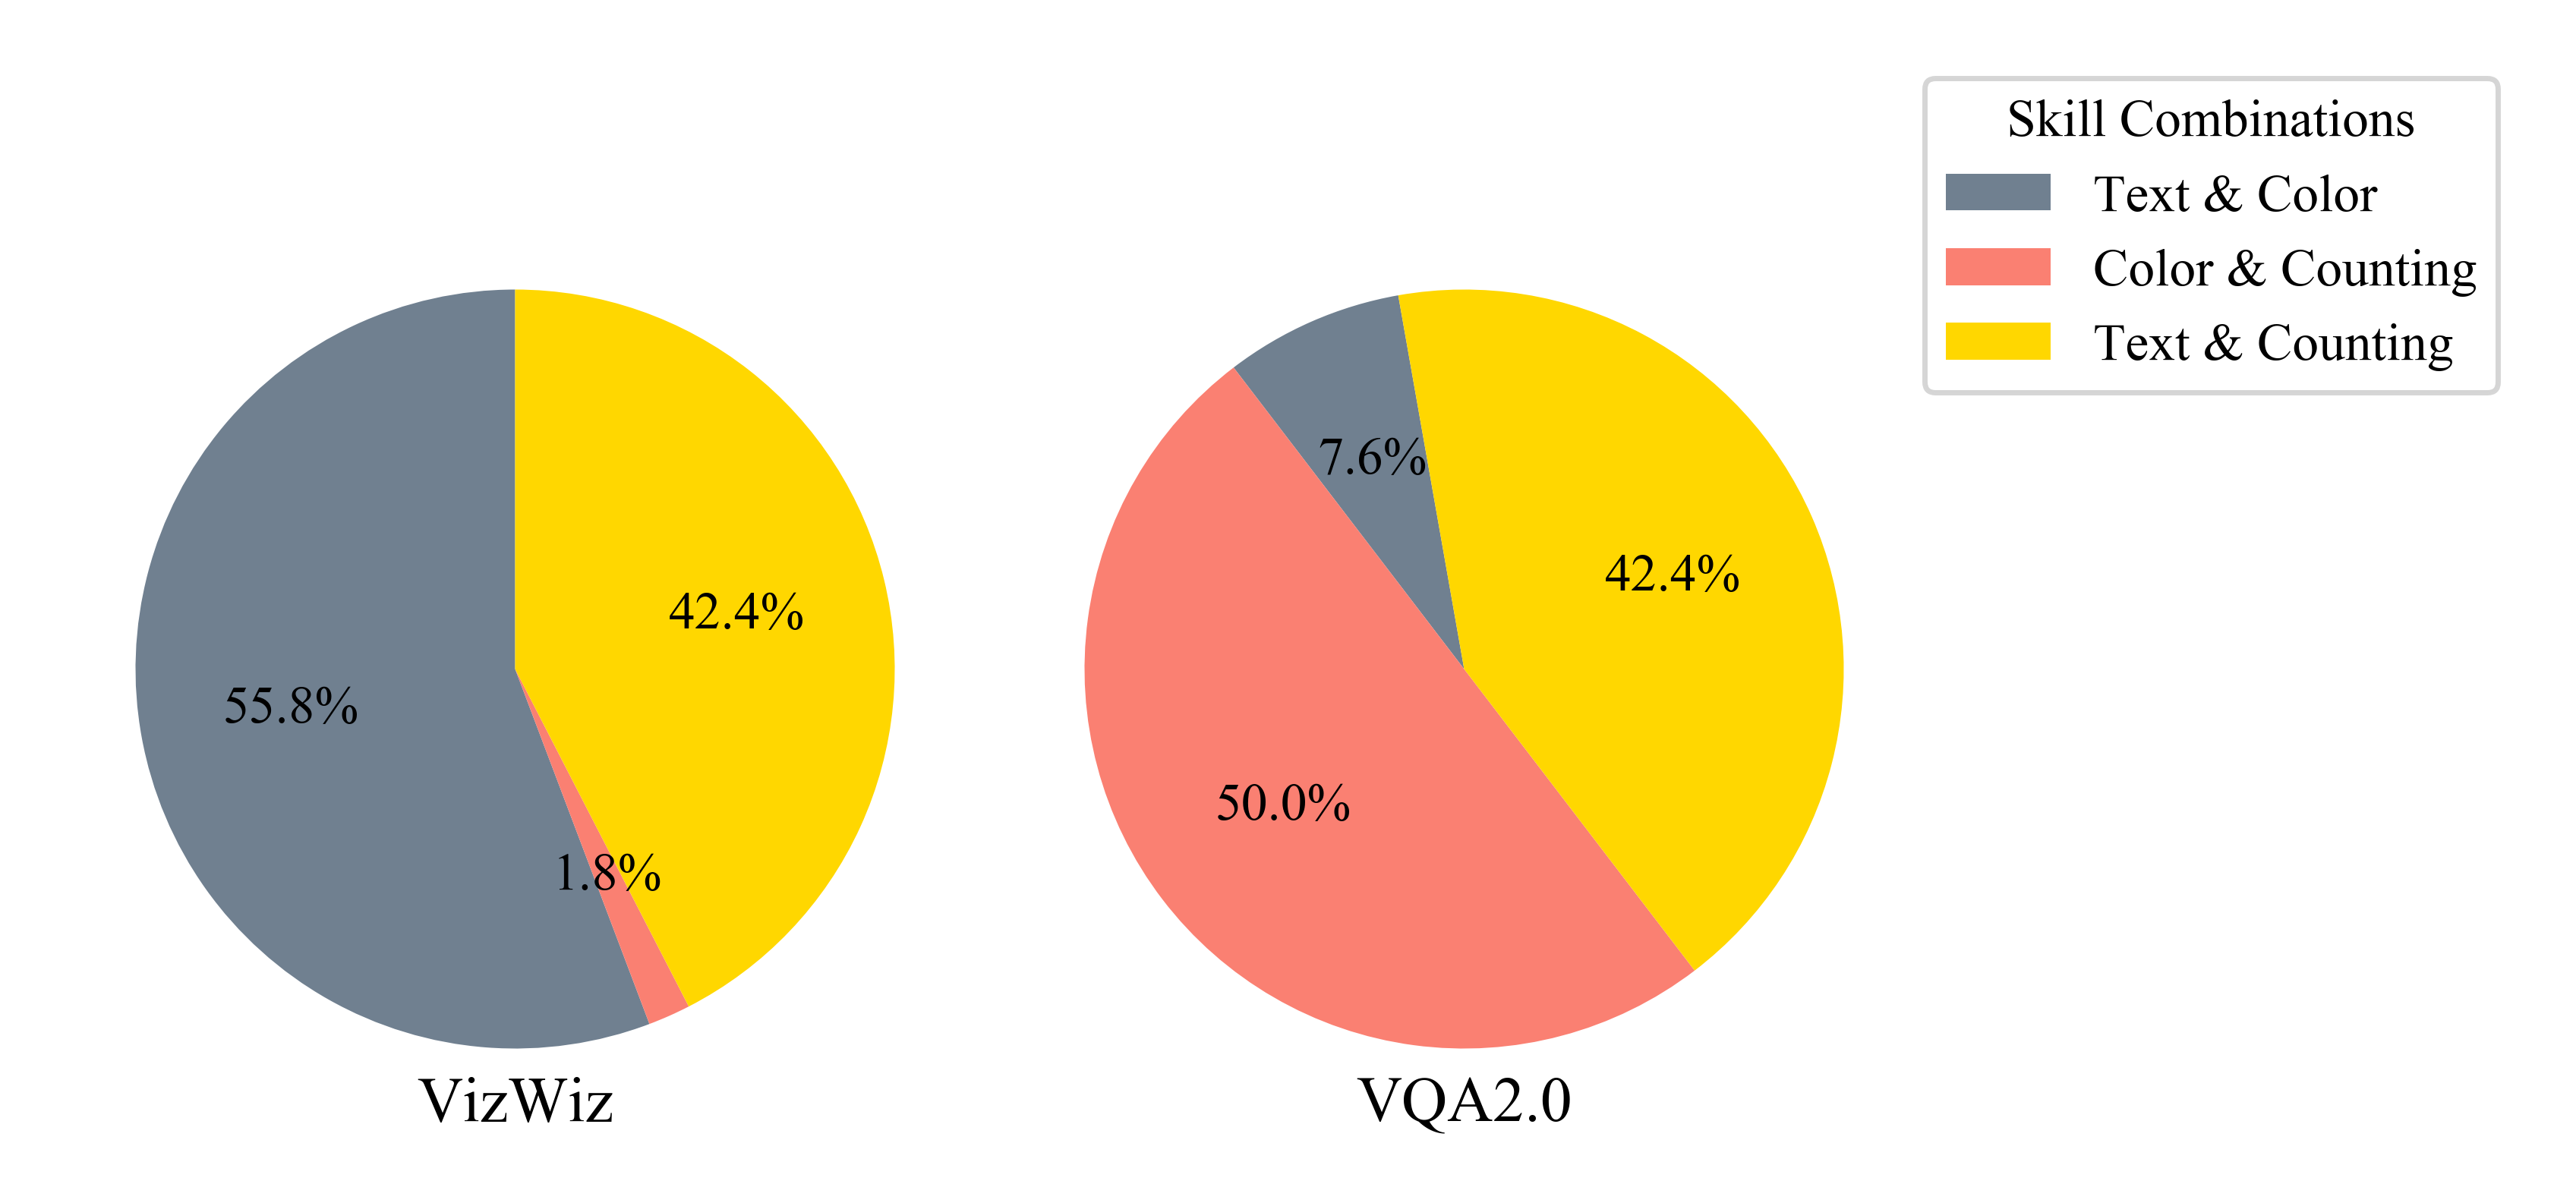

In [36]:
# pie charts of double skill distribution
fig.clear()
two_skill_labels = 'Text & Color', 'Color & Counting', 'Text & Counting'
vizwiz_sizes = [len(vizwiz_txt_col) / len(vizwiz_two_skills), 
                len(vizwiz_col_cnt) / len(vizwiz_two_skills), 
                len(vizwiz_txt_cnt) / len(vizwiz_two_skills)]
vqa_sizes = [len(vqa_txt_col) / len(vqa_two_skills), 
                len(vqa_col_cnt) / len(vqa_two_skills), 
                len(vqa_txt_cnt) / len(vqa_two_skills)]

fig = plt.figure(num=None, figsize=(5,5), dpi=500)

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)

ax1.pie(vizwiz_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=90, colors=['slategray', 'salmon', 'gold'])
ax1.set_title('VizWiz', y=-0.01)


ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(vqa_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=100, colors=['slategray', 'salmon', 'gold'])

ax2.set_title('VQA2.0',y=-0.01)

fig.legend(# labels=[x.split()[-1] for x in two_skill_labels],
            labels=two_skill_labels,
            title="Skill Combinations",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.subplots_adjust(wspace=2)

plt.show()

In [298]:
vqa.head(1)

,TXT,OBJ,COL,CNT,OTH
0,0,5,2,0,2


#### correlations between keywords and skill labels

In [37]:
def color_flag(row):
    if row['COL'] >= 3:
        return 1.
    else:
        return 0.
def color_kw(row):
    if 'color' in row['QSN'].lower():
        return 1.
    else:
        return 0.

keyword_vizwiz = vizwiz.copy()
keyword_vizwiz['color'] = keyword_vizwiz.apply(lambda row: color_flag(row), axis=1)
keyword_vizwiz['kw'] = keyword_vizwiz.apply(lambda row: color_kw(row), axis=1)

keyword_vqa = vqa.copy()
keyword_vqa['color'] = vqa.apply(lambda row: color_flag(row), axis=1)
keyword_vqa['kw'] = vqa.apply(lambda row: color_kw(row), axis=1)

In [27]:
keyword_vizwiz['color'].corr(keyword_vizwiz['kw'])

0.7556347884001726

In [39]:
keyword_vqa['color'].corr(keyword_vqa['kw'])

0.592911610457613

In [45]:
# percentage of color question that ask about clothing 

vizwiz_color = vizwiz.loc[vizwiz['COL'] >= 3]
kws = {'shoe', 'shoes', 'shirts', 'pants', 'shirt', 'pant', 'dress', 'skirt', 'hat', 'cap', 'clothes', 'cloth'}
ct = 0
for i, row in vizwiz_color.iterrows():
    question = row['QSN'].lower().strip().split()
    for word in question:
        if word in kws:
            ct += 1

ct / len(vizwiz_color)

0.05587275693311582

In [97]:
# keyword with counting skill

vqa_cnt = vqa.loc[vqa['CNT'] >= 3]
ct = 0
kws = {'many', 'much'}

for i, row in vqa_cnt.iterrows():
    question = row['QSN'].lower().strip().split()
    for word in question:
        if word in kws:
            ct += 1

ct / len(vqa_cnt)

0.8489208633093526

In [100]:
def cnt_flag(row):
    if row['CNT'] >= 3:
        return 1.
    else:
        return 0.

def cnt_kw(row):
    if 'many' in row['QSN'].lower() or 'much' in row['QSN'].lower():
        return 1.
    else:
        return 0.
    
keyword_vqa = vqa.copy()
keyword_vqa['cnt'] = keyword_vqa.apply(lambda row: cnt_flag(row), axis=1)
keyword_vqa['kw'] = keyword_vqa.apply(lambda row: cnt_kw(row), axis=1)

keyword_vqa['cnt'].corr(keyword_vqa['kw'])

0.847752200163352

In [103]:
for i, row in vizwiz.iterrows():
    if 'how many' in row['QSN'].lower():
        print(row)

Unnamed: 0                                             11363
QID                            VizWiz_train_000000000900.jpg
TXT                                                        0
OBJ                                                        5
COL                                                        0
CNT                                                        5
OTH                                                        0
SRC_DATASET                                           VizWiz
ANS_TYP                                               number
IMG                            VizWiz_train_000000000900.jpg
QSN                    How many toes does this person have? 
ANS1                                                      10
ANS2                                                       9
ANS3                                                      10
ANS4                                                      10
ANS5                                                      10
ANS6                    

Unnamed: 0                                      13795
QID                     VizWiz_train_000000004261.jpg
TXT                                                 5
OBJ                                                 3
COL                                                 1
CNT                                                 0
OTH                                                 0
SRC_DATASET                                    VizWiz
ANS_TYP                                        number
IMG                     VizWiz_train_000000004261.jpg
QSN                    How many calories are in this?
ANS1                                              300
ANS2                                               50
ANS3                                               50
ANS4                                              300
ANS5                                   50 per serving
ANS6                       50 calories per oz serving
ANS7                                               50
ANS8                        

Unnamed: 0                                                         16105
QID                                        VizWiz_train_000000007521.jpg
TXT                                                                    2
OBJ                                                                    5
COL                                                                    1
CNT                                                                    3
OTH                                                                    0
SRC_DATASET                                                       VizWiz
ANS_TYP                                                     unanswerable
IMG                                        VizWiz_train_000000007521.jpg
QSN                    What is this remote and how many buttons does ...
ANS1                                                          unsuitable
ANS2                                                     verizon fios 49
ANS3                                               

Unnamed: 0                                      18551
QID                     VizWiz_train_000000010938.jpg
TXT                                                 3
OBJ                                                 4
COL                                                 0
CNT                                                 2
OTH                                                 1
SRC_DATASET                                    VizWiz
ANS_TYP                                        number
IMG                     VizWiz_train_000000010938.jpg
QSN                    How many calories are in this?
ANS1                                              180
ANS2                                              180
ANS3                                              180
ANS4                                              180
ANS5                                              180
ANS6                                     180 calories
ANS7                                              180
ANS8                        

Unnamed: 0                                                         20828
QID                                        VizWiz_train_000000014105.jpg
TXT                                                                    4
OBJ                                                                    5
COL                                                                    1
CNT                                                                    1
OTH                                                                    0
SRC_DATASET                                                       VizWiz
ANS_TYP                                                     unanswerable
IMG                                        VizWiz_train_000000014105.jpg
QSN                    Can you tell me what this frozen dinner is and...
ANS1                                                               qwdqd
ANS2                                                               palak
ANS3                                               

Unnamed: 0                                     21406
QID                    VizWiz_train_000000014915.jpg
TXT                                                0
OBJ                                                2
COL                                                1
CNT                                                1
OTH                                                0
SRC_DATASET                                   VizWiz
ANS_TYP                                       number
IMG                    VizWiz_train_000000014915.jpg
QSN                                How many fingers?
ANS1                                               5
ANS2                                               5
ANS3                                               5
ANS4                                               5
ANS5                                               5
ANS6                                               5
ANS7                                               5
ANS8                                          

Unnamed: 0                                                         22362
QID                                        VizWiz_train_000000016284.jpg
TXT                                                                    1
OBJ                                                                    4
COL                                                                    1
CNT                                                                    5
OTH                                                                    0
SRC_DATASET                                                       VizWiz
ANS_TYP                                                           number
IMG                                        VizWiz_train_000000016284.jpg
QSN                    How many lights are visible on the battery cha...
ANS1                                                                   3
ANS2                                                                   3
ANS3                                               

Unnamed: 0                                                   26016
QID                                    VizWiz_val_000000029410.jpg
TXT                                                              4
OBJ                                                              4
COL                                                              0
CNT                                                              2
OTH                                                              0
SRC_DATASET                                                 VizWiz
ANS_TYP                                               unanswerable
IMG                                    VizWiz_val_000000029410.jpg
QSN                    How many calories in a serving of Cheerios?
ANS1                                                           110
ANS2                                                  image plurry
ANS3                                                           104
ANS4                                                          

Unnamed: 0                                         5176
QID                        VizWiz_test_000000020195.jpg
TXT                                                   3
OBJ                                                   5
COL                                                   2
CNT                                                   0
OTH                                                   0
SRC_DATASET                                      VizWiz
ANS_TYP                                          number
IMG                        VizWiz_test_000000020195.jpg
QSN                    How many calories are in Ensure?
ANS1                                       unanswerable
ANS2                                                350
ANS3                                                1.5
ANS4                                                350
ANS5                                         unsuitable
ANS6                                                1.5
ANS7                                            

Unnamed: 0                                          7424
QID                         VizWiz_test_000000023374.jpg
TXT                                                    0
OBJ                                                    4
COL                                                    1
CNT                                                    4
OTH                                                    0
SRC_DATASET                                       VizWiz
ANS_TYP                                           number
IMG                         VizWiz_test_000000023374.jpg
QSN                    How many fingers am I holding up?
ANS1                                                   2
ANS2                                                   2
ANS3                                                   2
ANS4                                                   2
ANS5                                                   2
ANS6                                                   2
ANS7                           

Unnamed: 0                                     9414
QID                    VizWiz_test_000000026166.jpg
TXT                                               4
OBJ                                               2
COL                                               1
CNT                                               3
OTH                                               0
SRC_DATASET                                  VizWiz
ANS_TYP                                      number
IMG                    VizWiz_test_000000026166.jpg
QSN                             How many gigabytes?
ANS1                                              2
ANS2                                              2
ANS3                                           2 gb
ANS4                                 2000 gigabytes
ANS5                                            kgb
ANS6                                              2
ANS7                                              2
ANS8                                              2
ANS9        

In [60]:
# example 
for i, q in enumerate(vizwiz['QSN'].tolist()):
    if "clean" in q:
        print(i, q) # i = 4165

9 Surface look clean? Thank you.
434 What kind of cleaner is this?
803 What cleaning product is this? What cleaning product is this?
1200 What kind of cleaner is this?
1295 Does that look clean? Thank you.
1706 Does my white cane look clean?
1802 Does this look clean?
1872 What kind of cleaner is this? Thank you.
3508 What cleaner is this?
4059 Is the bathroom cleaned?  Thank you.
4165 Does this look clean?
4475 What is this cleaner?
4524 What kind of cleaner is this?
4620 How clean does this boot look? I just tried to wash it but there might still be some stains.
4920 How clean is this toilet? Thank you.
5307 Is my shirt clean?
6039 What is this cleaning product?
6571 Is this shirt clean or dirty?
6598 What kind of cleaning product is this?
7368 What cleaning product is this?
7788 What is this cleaner?
8820 Does this look clean?
9052 Is this carpet clean?
9193 What cleaning product is this?
10372 Does this look clean? Thank you.
10590 Does this look clean?  Thank you.
10779 I was just

In [79]:
# https://ivc.ischool.utexas.edu/VizWiz/data/Images/
vizwiz.iloc[12652, :]

Unnamed: 0                                            23408
QID                           VizWiz_train_000000017733.jpg
TXT                                                       0
OBJ                                                       5
COL                                                       2
CNT                                                       0
OTH                                                       0
SRC_DATASET                                          VizWiz
ANS_TYP                                              yes/no
IMG                           VizWiz_train_000000017733.jpg
QSN                    This surface look clean?  Thank you.
ANS1                                                    yes
ANS2                                                    yes
ANS3                                                    yes
ANS4                                                    yes
ANS5                                                    yes
ANS6                                    

In [73]:
# xx\% in VizWiz are variants of ``What is this?"

ct = 0
what_list = ["what is this", "what is that", "what's this", "what's that", "what are", "what is it"]
for i, q in enumerate(vizwiz['QSN'].tolist()):
    for w in what_list:
        if w in q:
            # print(q)
            ct += 1
ct / len(vizwiz)

0.025105732025555657

In [88]:
vqa.iloc[65, :]

Unnamed: 0                                          65
QID                                          107119000
TXT                                                  2
OBJ                                                  3
COL                                                  3
CNT                                                  0
OTH                                                  0
SRC_DATASET                                        VQA
ANS_TYP                                          other
IMG                    COCO_train2014_000000107119.jpg
QSN                        Which side is player 14 on?
ANS1                                      kickers side
ANS2                                              left
ANS3                                              left
ANS4                                              blue
ANS5                                              left
ANS6                                          opposing
ANS7                                         blue team
ANS8      

#### most frequent words in each dataset/skill category

In [95]:
# write out txt to get high freq words
vizwiz_color = vizwiz.loc[vizwiz['COL'] >= 3]
vizwiz_text = vizwiz.loc[vizwiz['TXT'] >= 3]
vizwiz_counting = vizwiz.loc[vizwiz['CNT'] >= 3]


vqa_color = vqa.loc[vqa['COL'] >= 3]
vqa_text = vqa.loc[vqa['TXT'] >= 3]
vqa_counting = vqa.loc[vqa['CNT'] >= 3]


with open(f'vizwiz_color.txt', 'w+') as f:
    f.write("%s\n" % vizwiz_color['QSN'].tolist())
with open(f'vizwiz_text.txt', 'w+') as f:
    f.write("%s\n" % vizwiz_text['QSN'].tolist())
with open(f'vizwiz_counting.txt', 'w+') as f:
    f.write("%s\n" % vizwiz_counting['QSN'].tolist())

with open(f'vqa_color.txt', 'w+') as f:
    f.write("%s\n" % vqa_color['QSN'].tolist())
with open(f'vqa_text.txt', 'w+') as f:
    f.write("%s\n" % vqa_text['QSN'].tolist())
with open(f'vqa_counting.txt', 'w+') as f:
    f.write("%s\n" % vqa_counting['QSN'].tolist())

In [12]:
len(vqa.loc[vqa['CNT'] >= 3]) / len(vqa)

0.16567342073897498

In [11]:
len(vqa_test)

1291

## 'none of the above' ratios

In [9]:
len(vizwiz.loc[(vizwiz['COL'] == 0) & 
           (vizwiz['TXT'] == 0) & 
           (vizwiz['CNT'] == 0) & 
           (vizwiz['OBJ'] == 0) & 
           (vizwiz['OTH'] == 0)]) / len(vizwiz)

0.0

In [10]:
len(vqa.loc[(vqa['COL'] == 0) & 
           (vqa['TXT'] == 0) & 
           (vqa['CNT'] == 0) & 
           (vqa['OBJ'] == 0) & 
           (vqa['OTH'] == 0)]) / len(vqa)

0.0

## examples of skills
https://ivc.ischool.utexas.edu/VizWiz/data/Images/

In [48]:
dset = vizwiz
dset.loc[(dset['OTH'] >= 3) & 
        (dset['OBJ'] > 0) &
        (dset['COL'] > 0) & 
        (dset['TXT'] == 0) &
        (dset['CNT'] == 0)]

,Unnamed: 0,QID,TXT,OBJ,COL,CNT,OTH,SRC_DATASET,ANS_TYP,IMG,...,ANS4,ANS5,ANS6,ANS7,ANS8,ANS9,ANS10,NUM_UNIQUE_ANS,NUM_MOST_COMMON_ANS,split
4620,15376,VizWiz_train_000000006511.jpg,0,5,2,0,3,VizWiz,other,VizWiz_train_000000006511.jpg,...,very clean,clean,clean,somewhat clean,clean,clean,clean,5,5,train


In [ ]:
# OBJ = https://ivc.ischool.utexas.edu/VizWiz/data/Images/VizWiz_train_000000001455.jpg
# https://ivc.ischool.utexas.edu/VizWiz/data/Images/VizWiz_test_000000027724.jpg

# TXT 
# https://ivc.ischool.utexas.edu/VizWiz/data/Images/VizWiz_train_000000002719.jpg

# COL
# https://ivc.ischool.utexas.edu/VizWiz/data/Images/VizWiz_train_000000007606.jpg

# CNT 
# https://ivc.ischool.utexas.edu/VizWiz/data/Images/VizWiz_train_000000006397.jpg

# OTH
# VizWiz_train_000000006511.jpg

In [64]:
dset = vqa
dset.loc[(dset['OBJ'] == 2) & 
        (dset['OTH'] == 0) &
        (dset['COL'] == 0) & 
        (dset['TXT'] == 0) &
        (dset['CNT'] == 5)][['QSN', 'IMG']]

,QSN,IMG
744,How many are there?,COCO_train2014_000000176462.jpg
2678,How many people might live here?,COCO_train2014_000000379522.jpg
2749,How many dividers are there?,COCO_train2014_000000387329.jpg
268,How many people are seated?,COCO_train2014_000000464854.jpg
285,How many chefs are there?,COCO_train2014_000000520685.jpg


In [120]:
vqa.loc[vqa['IMG'] == 'COCO_train2014_000000419391.jpg']['QSN']

3058    What does the text read?
Name: QSN, dtype: object

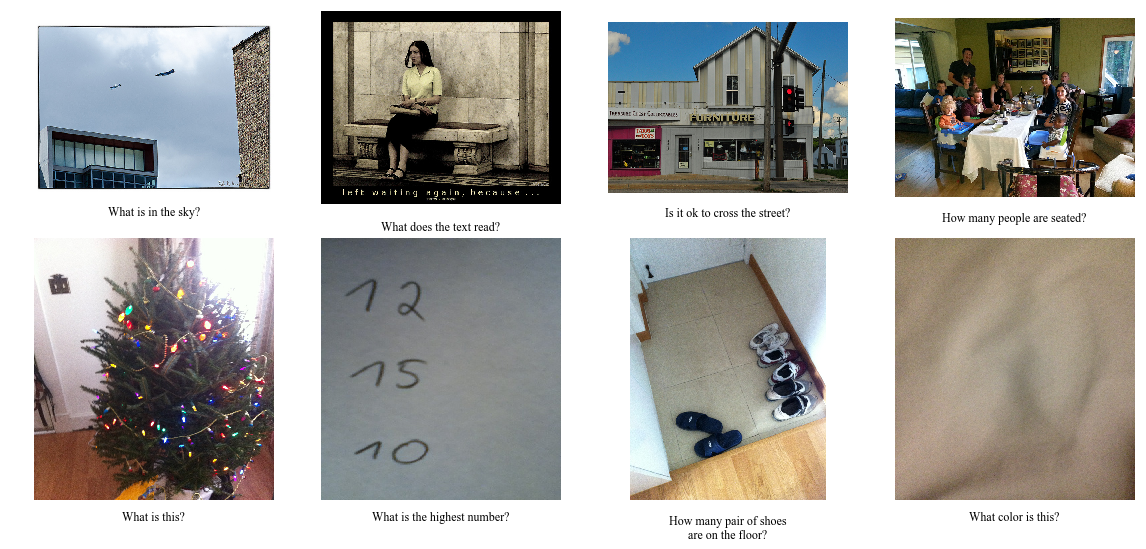

In [238]:
from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.mpl_axes import Axes
import mpl_toolkits.axes_grid.axes_size as Size
from mpl_toolkits.axes_grid import Divider
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16,8)) # TODO set dpi

ax1 = fig.add_subplot(2,4,1, adjustable='box')
vqa_asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
vqa_asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
vqa_obj = mpimg.imread('../../vqa_examples/obj_COCO_train2014_000000117262.jpg')
ax1.set_title(label='What is in the sky?', loc='center', y=-0.17)
ax1.imshow(vqa_obj)
ax1.set_axis_off()
ax1.patch.set_edgecolor('black')  
ax1.patch.set_linewidth('2')
ax1.set_aspect(vqa_asp)

ax2 = fig.add_subplot(2,4,2)
vqa_txt = mpimg.imread('../../vqa_examples/txt_COCO_train2014_000000419391.jpg')
ax2.set_title(label='What does the text read?', loc='center', y=-0.17)
ax2.imshow(vqa_txt)
ax2.set_axis_off()
ax2.patch.set_edgecolor('black')  
ax2.patch.set_linewidth('2')
ax2.set_aspect(vqa_asp)


ax3 = fig.add_subplot(2,4,3)
vqa_col = mpimg.imread('../../vqa_examples/col_COCO_train2014_000000478738.jpg')
ax3.set_title(label='Is it ok to cross the street?', loc='center', y=-0.17)
ax3.imshow(vqa_col)
ax3.set_axis_off()
ax3.patch.set_edgecolor('black')  
ax3.patch.set_linewidth('2')  

ax4 = fig.add_subplot(2,4,4)
vqa_cnt = mpimg.imread('../../vqa_examples/cnt_COCO_train2014_000000464854.jpg')
ax4.imshow(vqa_cnt)
ax4.set_title(label='How many people are seated?', loc='center', y=-0.17)
ax4.set_axis_off()
ax4.patch.set_edgecolor('black')
ax4.patch.set_linewidth('2')

# vizwiz 
ax5 = fig.add_subplot(2,4,5)
vizwiz_obj = mpimg.imread('../../vizwiz_examples/VizWiz_test_000000027724.jpg')
ax5.set_title(label='What is this?', loc='center', y=-0.1)
ax5.imshow(vizwiz_obj, aspect='auto')
ax5.set_axis_off()
ax5.patch.set_edgecolor('black')
ax5.patch.set_linewidth('2')

ax6 = fig.add_subplot(2,4,6)
vizwiz_txt = mpimg.imread('../../vizwiz_examples/VizWiz_train_000000002719.jpg')
ax6.set_title(label='What is the highest number?', loc='center', y=-0.1)
ax6.imshow(vizwiz_txt, aspect='auto')
ax6.set_axis_off()
ax6.patch.set_edgecolor('black')
ax6.patch.set_linewidth('2')

ax7 = fig.add_subplot(2,4,7)
vizwiz_cnt = mpimg.imread('../../vizwiz_examples/VizWiz_train_000000006397.jpg')
ax7.set_title(label='How many pair of shoes\nare on the floor?', loc='center', y=-0.17)
ax7.imshow(vizwiz_cnt)
ax7.set_axis_off()
ax7.patch.set_edgecolor('black')
ax7.patch.set_linewidth('2')

ax8 = fig.add_subplot(2,4,8)
vizwiz_txt = mpimg.imread('../../vizwiz_examples/VizWiz_train_000000007606.jpg')
ax8.set_title(label='What color is this?', loc='center', y=-0.1)
ax8.imshow(vizwiz_txt, aspect='auto')
ax8.set_axis_off()
ax8.patch.set_edgecolor('black')
ax8.patch.set_linewidth('2')


fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

In [136]:
vizwiz.loc[vizwiz['IMG'] == 'VizWiz_train_000000002719.jpg']['QSN']

1932    What is the highest number?
Name: QSN, dtype: object

### Contractions clean up

In [20]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"cant": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"didnt": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oclock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"theirs": "their has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what is",
"whats": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"yall": "you all",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def clean_up_contractions(question):
    q = copy.deepcopy(question)
    words = q.split(' ')
    for w in words:
        q = q.replace('"', '')
        if w in contractions:
            q = q.replace(w, contractions[w])
    return q

## sunburst plot

In [30]:
# clean up contractions & lowercase

vizwiz_obj_qsn = vizwiz.loc[(vizwiz['OBJ'] >= 3)]['QSN'].str.lower()
vizwiz_col_qsn = vizwiz.loc[vizwiz['COL'] >= 3]['QSN'].str.lower()
vizwiz_txt_qsn = vizwiz.loc[vizwiz['TXT'] >= 3]['QSN'].str.lower()
vizwiz_cnt_qsn = vizwiz.loc[vizwiz['CNT'] >= 3]['QSN'].str.lower()

vqa_obj_qsn = vqa.loc[vqa['OBJ'] >= 3]['QSN'].str.lower()
vqa_col_qsn = vqa.loc[vqa['COL'] >= 3]['QSN'].str.lower()
vqa_txt_qsn = vqa.loc[vqa['TXT'] >= 3]['QSN'].str.lower()
vqa_cnt_qsn = vqa.loc[vqa['CNT'] >= 3]['QSN'].str.lower()

vizwiz_obj_qsn = [clean_up_contractions(q) for q in vizwiz_obj_qsn]
vizwiz_col_qsn = [clean_up_contractions(q) for q in vizwiz_col_qsn]
vizwiz_txt_qsn = [clean_up_contractions(q) for q in vizwiz_txt_qsn]
vizwiz_cnt_qsn = [clean_up_contractions(q) for q in vizwiz_cnt_qsn]

vqa_obj_qsn = [clean_up_contractions(q) for q in vqa_obj_qsn]
vqa_col_qsn = [clean_up_contractions(q) for q in vqa_col_qsn]
vqa_txt_qsn = [clean_up_contractions(q) for q in vqa_txt_qsn]
vqa_cnt_qsn = [clean_up_contractions(q) for q in vqa_cnt_qsn]

In [34]:
with open('vizwiz-obj.txt', 'a+') as f:
    for qsn in vizwiz_cnt_qsn:
        f.write(qsn.replace(' ', ',').replace('?', '').replace('.', ''))
        f.write('\n')

## all skill combinations in one chart

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ & OTH: 4.499235130027895e-05
COL & TXT: 0.00040493116170251057
COL & CNT: 0.0
COL & OTH: 0.0
TXT & CNT: 0.0013047781877080897
TXT & OTH: 0.0
CNT & OTH: 0.0
OBJ & COL & TXT: 0.01070817960946639
OBJ & TXT & CNT: 0.007153783856744354
OBJ & CNT & OTH: 0.0
COL & TXT & CNT: 0.0
COL & TXT & OTH: 0.0
TXT & CNT & OTH: 0.0
OBJ & TXT & OTH: 4.499235130027895e-05
COL & CNT & OTH: 0.0
OBJ & COL & CNT: 0.0003599388104022316
OBJ & CNT & OTH: 0.0
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0

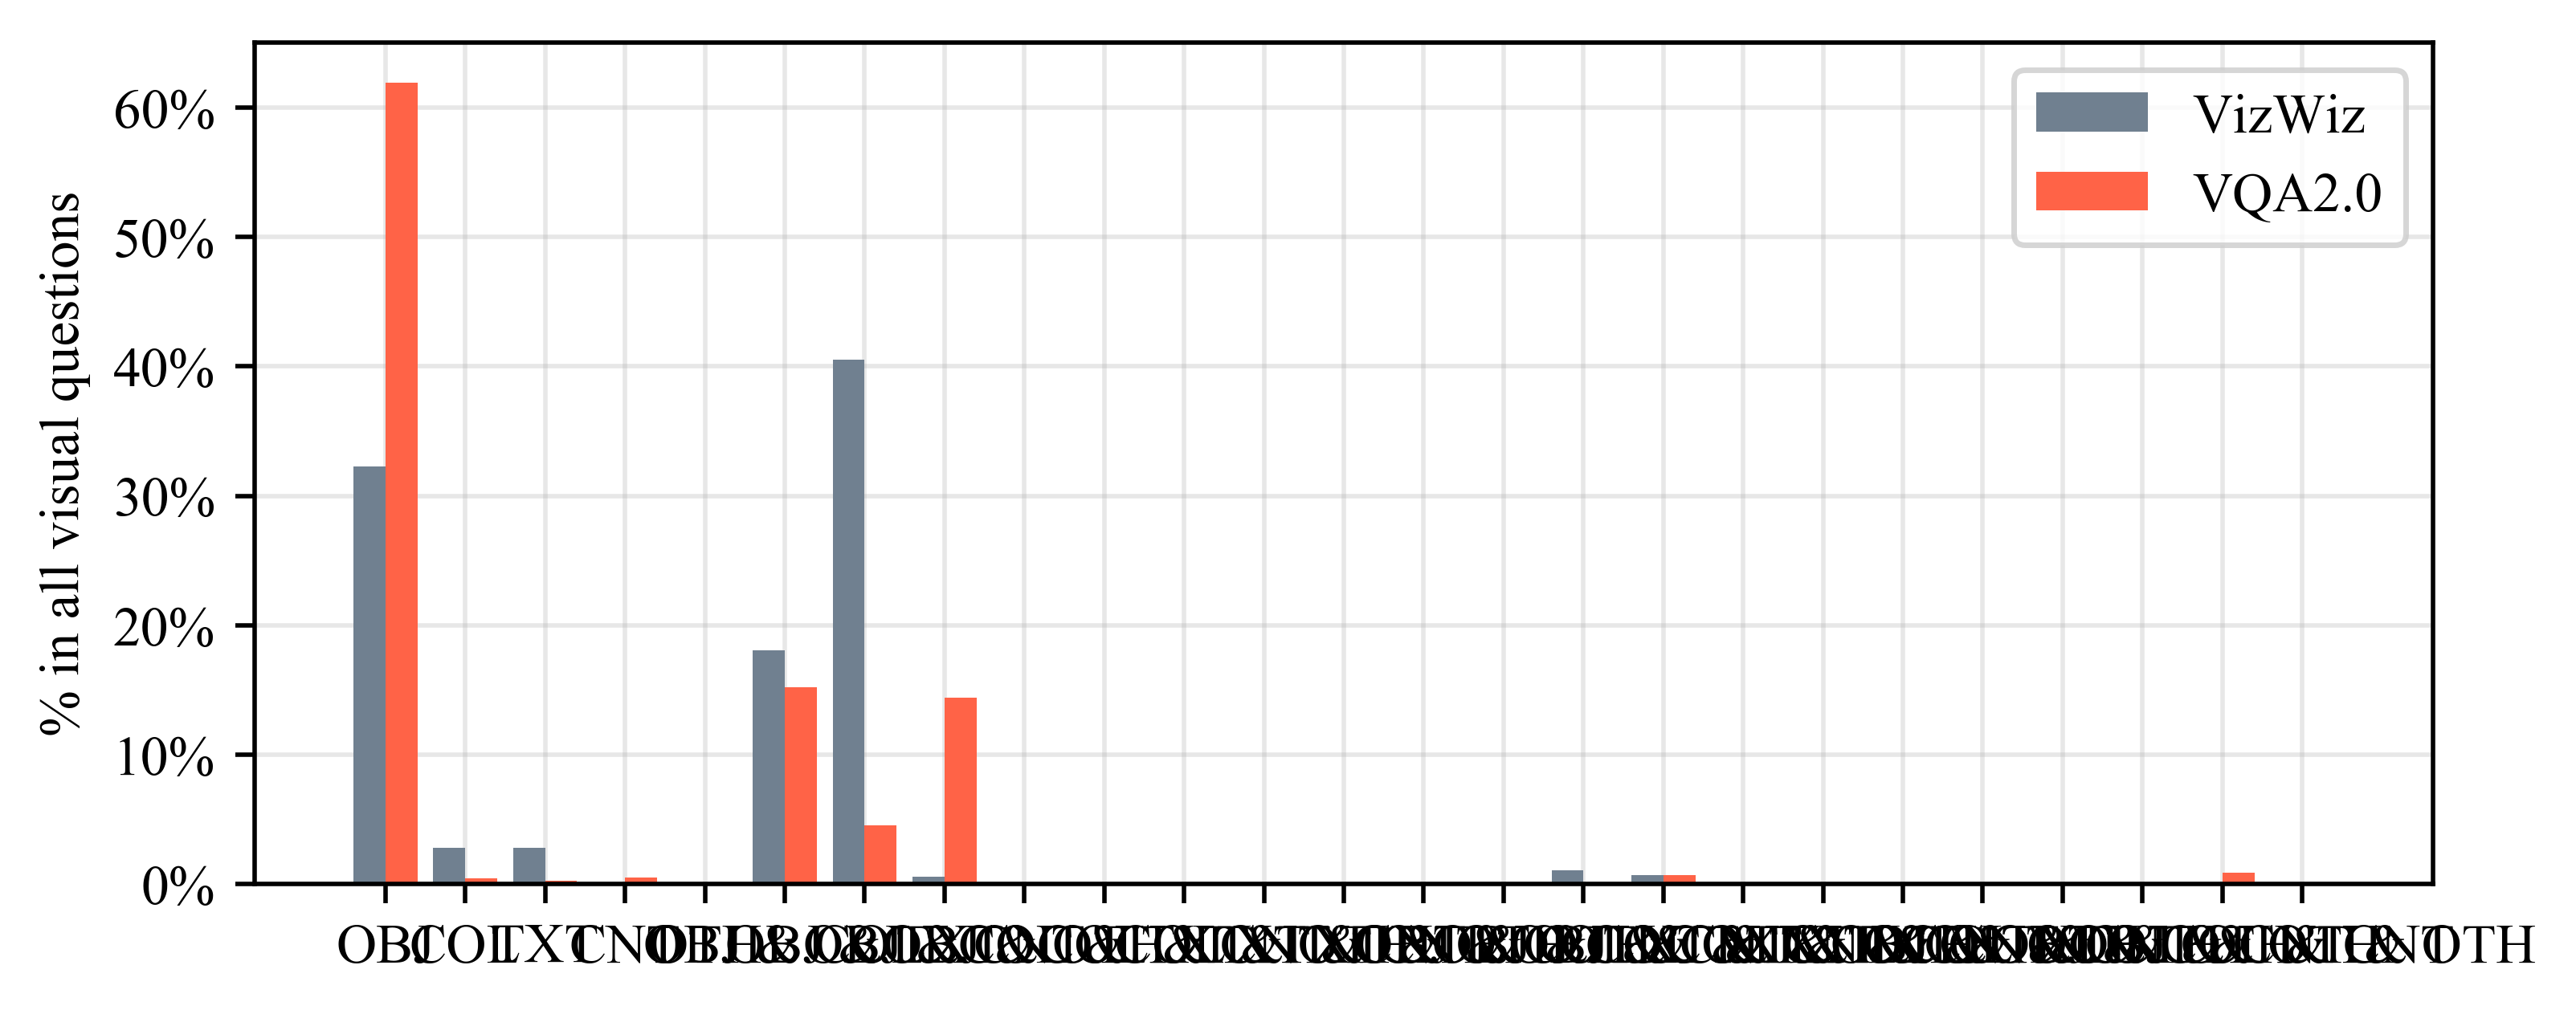

In [303]:
# one skill

fig = figure(num=None, figsize=(7, 10), dpi=500)
w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH',
         'OBJ & COL', 'OBJ & TXT', 'OBJ & CNT', 'OBJ & OTH',
         'COL & TXT', 'COL & CNT', 'COL & OTH', 'TXT & CNT', 'TXT & OTH', 'CNT & OTH',
         'OBJ & COL & TXT', 'OBJ & TXT & CNT', 'OBJ & CNT & OTH', 'COL & TXT & CNT', 'COL & TXT & OTH',
          'TXT & CNT & OTH', 'OBJ & TXT & OTH', 'COL & CNT & OTH', 'OBJ & COL & CNT', 'OBJ & CNT & OTH'
         ]

_one_skill = np.arange(len(skills))
dset = vizwiz
vizwiz_data = [one_skill(dset, 'OBJ'),
               one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), 
               one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH'),
               two_skills(dset, 'OBJ', 'COL'),
               two_skills(dset, 'OBJ', 'TXT'),
               two_skills(dset, 'OBJ', 'CNT'),
               two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'),
               two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'),
               two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'),
               two_skills(dset, 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'COL', 'TXT'),
               three_skills(dset, 'OBJ', 'TXT', 'CNT'),
               three_skills(dset, 'OBJ', 'CNT', 'OTH'),
               three_skills(dset, 'COL', 'TXT', 'CNT'),
               three_skills(dset, 'COL', 'TXT', 'OTH'),
               three_skills(dset, 'TXT', 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'TXT', 'OTH'),
               three_skills(dset, 'COL', 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'COL', 'CNT'),
               three_skills(dset, 'OBJ', 'CNT', 'OTH')
              ]
dset = vqa
vqa_data = [one_skill(dset, 'OBJ'),
               one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), 
               one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH'),
               two_skills(dset, 'OBJ', 'COL'),
               two_skills(dset, 'OBJ', 'TXT'),
               two_skills(dset, 'OBJ', 'CNT'),
               two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'),
               two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'),
               two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'),
               two_skills(dset, 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'COL', 'TXT'),
               three_skills(dset, 'OBJ', 'TXT', 'CNT'),
               three_skills(dset, 'OBJ', 'CNT', 'OTH'),
               three_skills(dset, 'COL', 'TXT', 'CNT'),
               three_skills(dset, 'COL', 'TXT', 'OTH'),
               three_skills(dset, 'TXT', 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'TXT', 'OTH'),
               three_skills(dset, 'COL', 'CNT', 'OTH'),
               three_skills(dset, 'OBJ', 'COL', 'CNT'),
               three_skills(dset, 'OBJ', 'CNT', 'OTH')
              ]

one_skill_plot = fig.add_subplot(3,1,1, sharex=None, sharey=None)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
#one_skill_plot.set_xlabel('Skill')
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
# one_skill_plot.set_title('Distributions of skills')
one_skill_plot.legend()

plt.subplots_adjust(hspace=.3)
plt.show()

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ & OTH: 4.499235130027895e-05
COL & TXT: 0.00040493116170251057
COL & CNT: 0.0
COL & OTH: 0.0
TXT & CNT: 0.0013047781877080897
TXT & OTH: 0.0
CNT & OTH: 0.0
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0.0


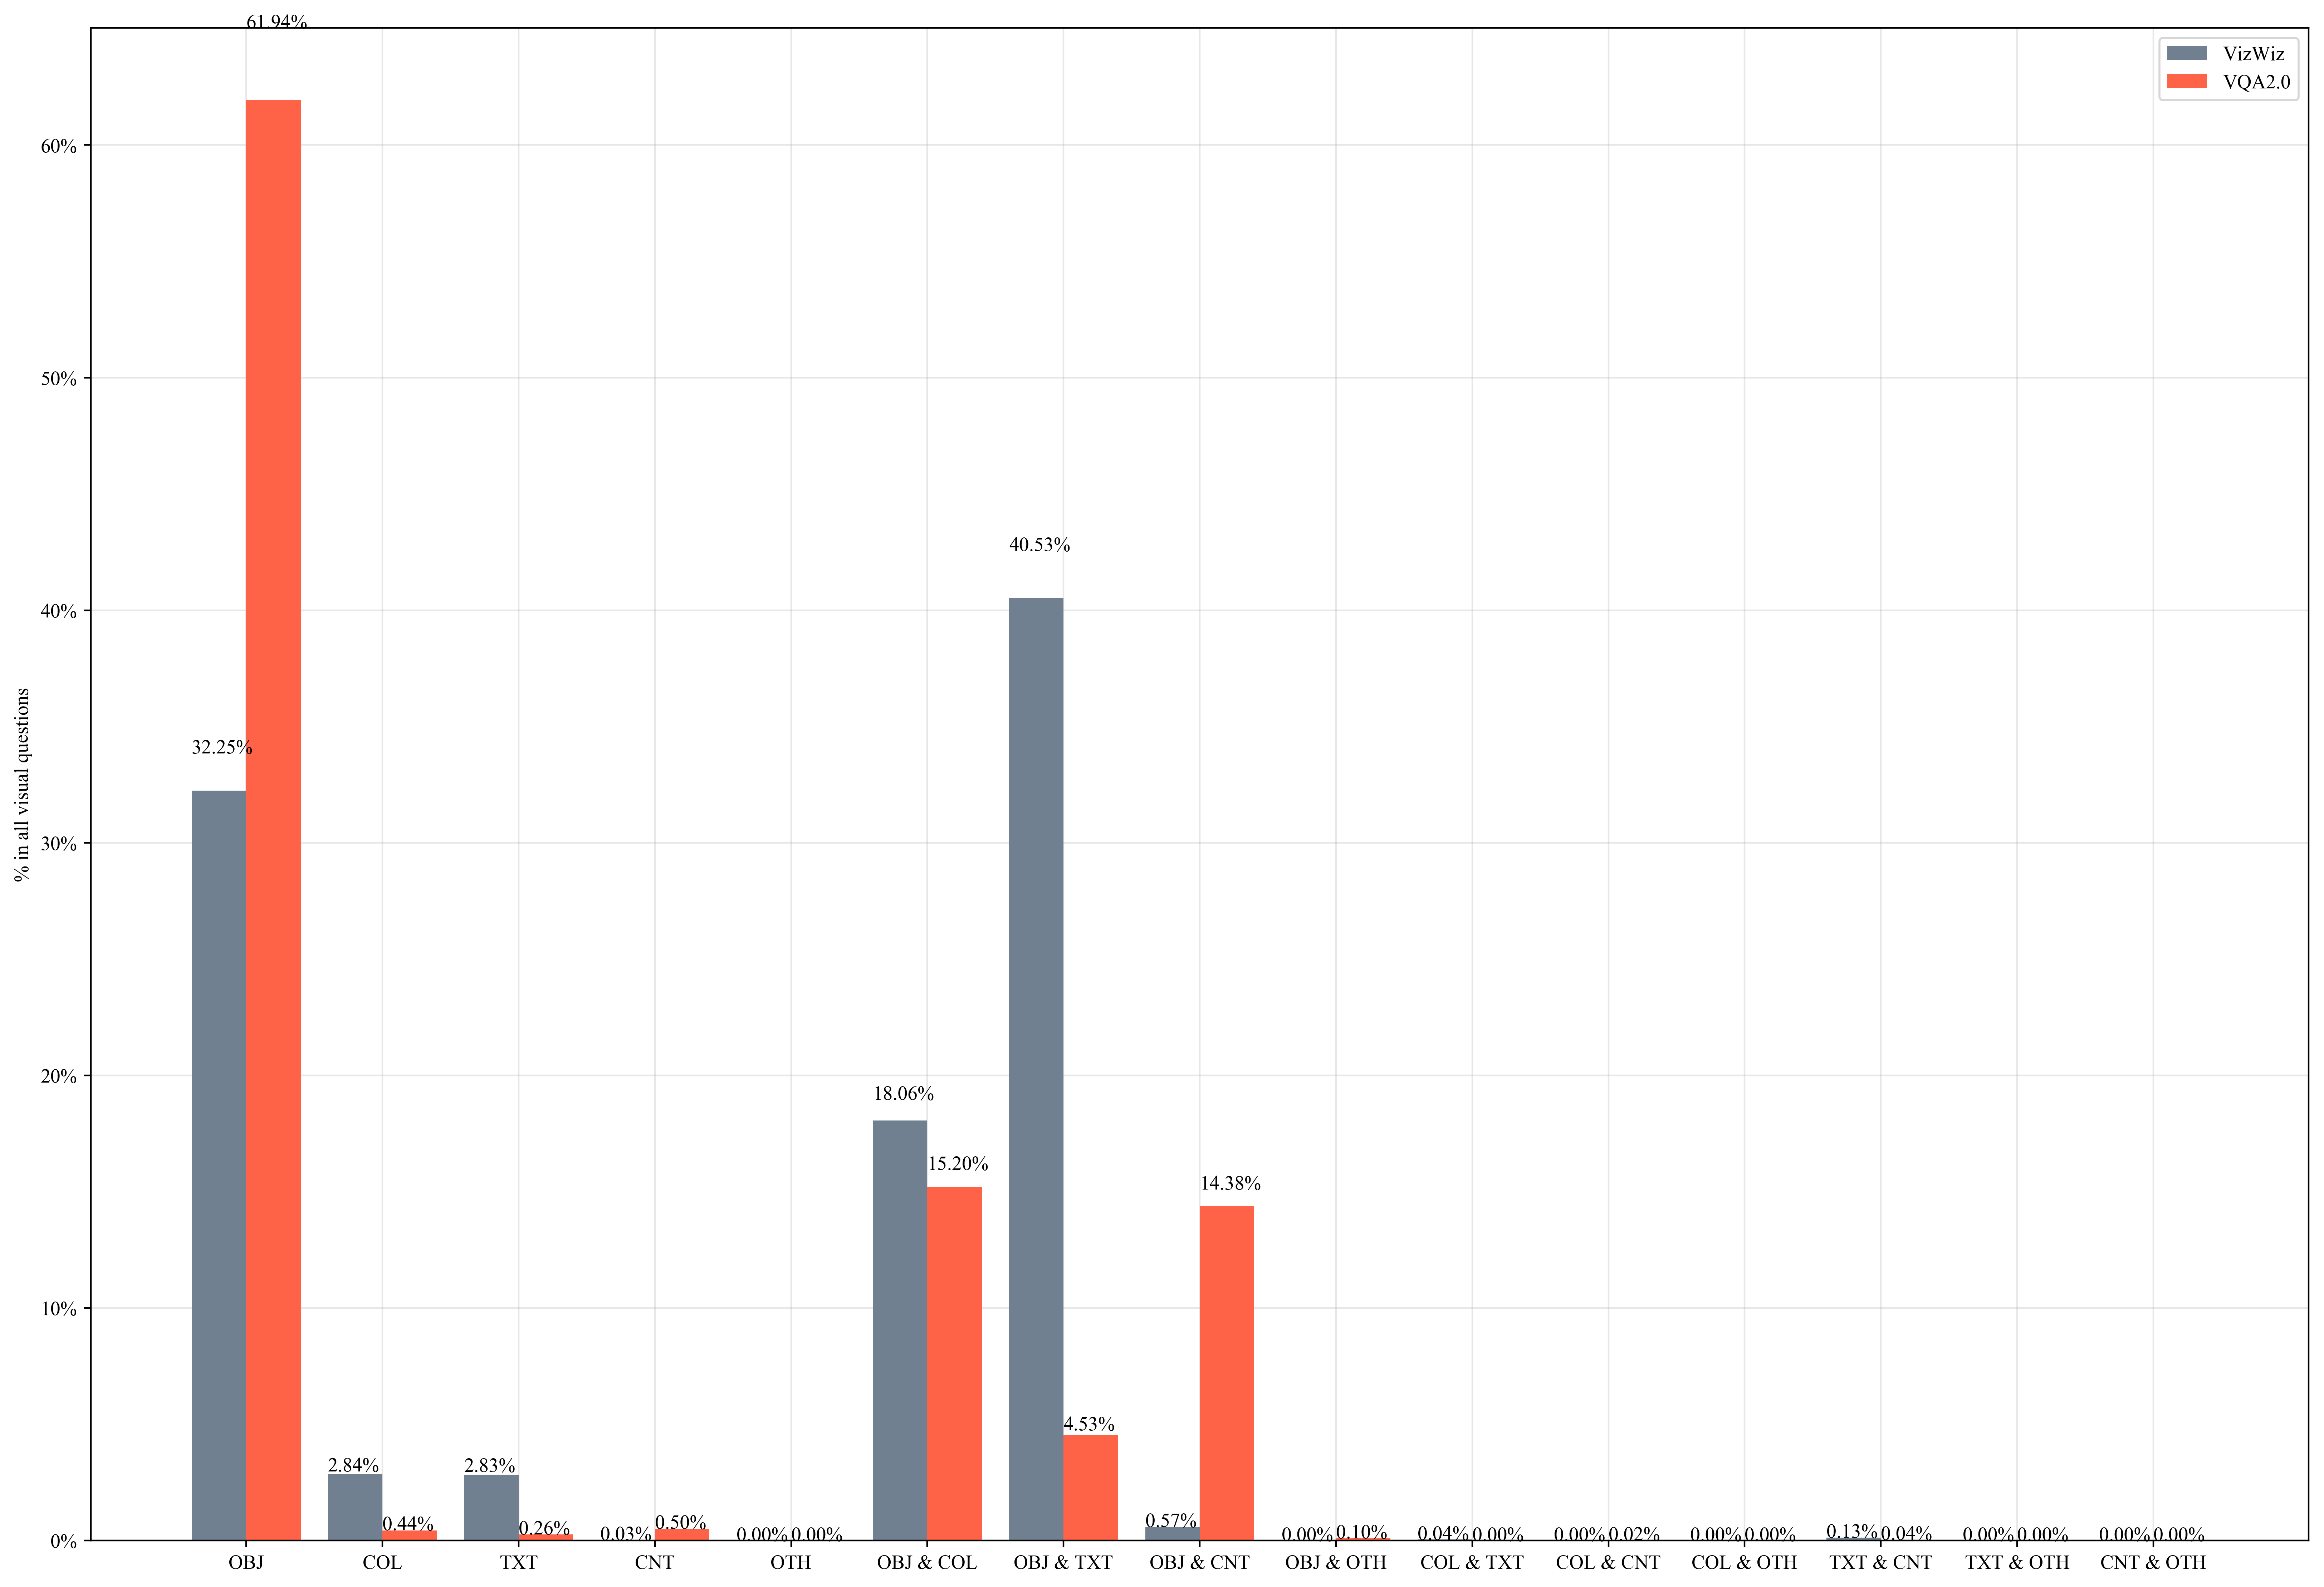

In [332]:
# one skill

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "10"

fig, one_skill_plot = plt.subplots(figsize=(20, 14), dpi=400)

w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH',
         'OBJ & COL', 'OBJ & TXT', 'OBJ & CNT', 'OBJ & OTH',
         'COL & TXT', 'COL & CNT', 'COL & OTH', 'TXT & CNT', 'TXT & OTH', 'CNT & OTH'
         ]

_one_skill = np.arange(len(skills))
dset = vizwiz
vizwiz_data = [one_skill(dset, 'OBJ'),
               one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), 
               one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH'),
               two_skills(dset, 'OBJ', 'COL'),
               two_skills(dset, 'OBJ', 'TXT'),
               two_skills(dset, 'OBJ', 'CNT'),
               two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'),
               two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'),
               two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'),
               two_skills(dset, 'CNT', 'OTH')
              ]
dset = vqa
vqa_data = [one_skill(dset, 'OBJ'),
               one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), 
               one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH'),
               two_skills(dset, 'OBJ', 'COL'),
               two_skills(dset, 'OBJ', 'TXT'),
               two_skills(dset, 'OBJ', 'CNT'),
               two_skills(dset, 'OBJ', 'OTH'),
               two_skills(dset, 'COL', 'TXT'),
               two_skills(dset, 'COL', 'CNT'),
               two_skills(dset, 'COL', 'OTH'),
               two_skills(dset, 'TXT', 'CNT'),
               two_skills(dset, 'TXT', 'OTH'),
               two_skills(dset, 'CNT', 'OTH')
              ]

#one_skill_plot = fig.add_subplot(3,1,1, sharex=None, sharey=None)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
vizwiz_bars = one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
vqa_bars = one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')

# add percentages on top of each bar
for i, bar in enumerate(vizwiz_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vizwiz_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()), y=(1.05 * height),
                        s=percentage)
for i, bar in enumerate(vqa_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vqa_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()), y=(1.05 * height),
                        s=percentage)

one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
#one_skill_plot.set_xlabel('Skill')
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
# one_skill_plot.set_title('Distributions of skills')
one_skill_plot.legend()

plt.subplots_adjust(hspace=.3)
plt.show()

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764


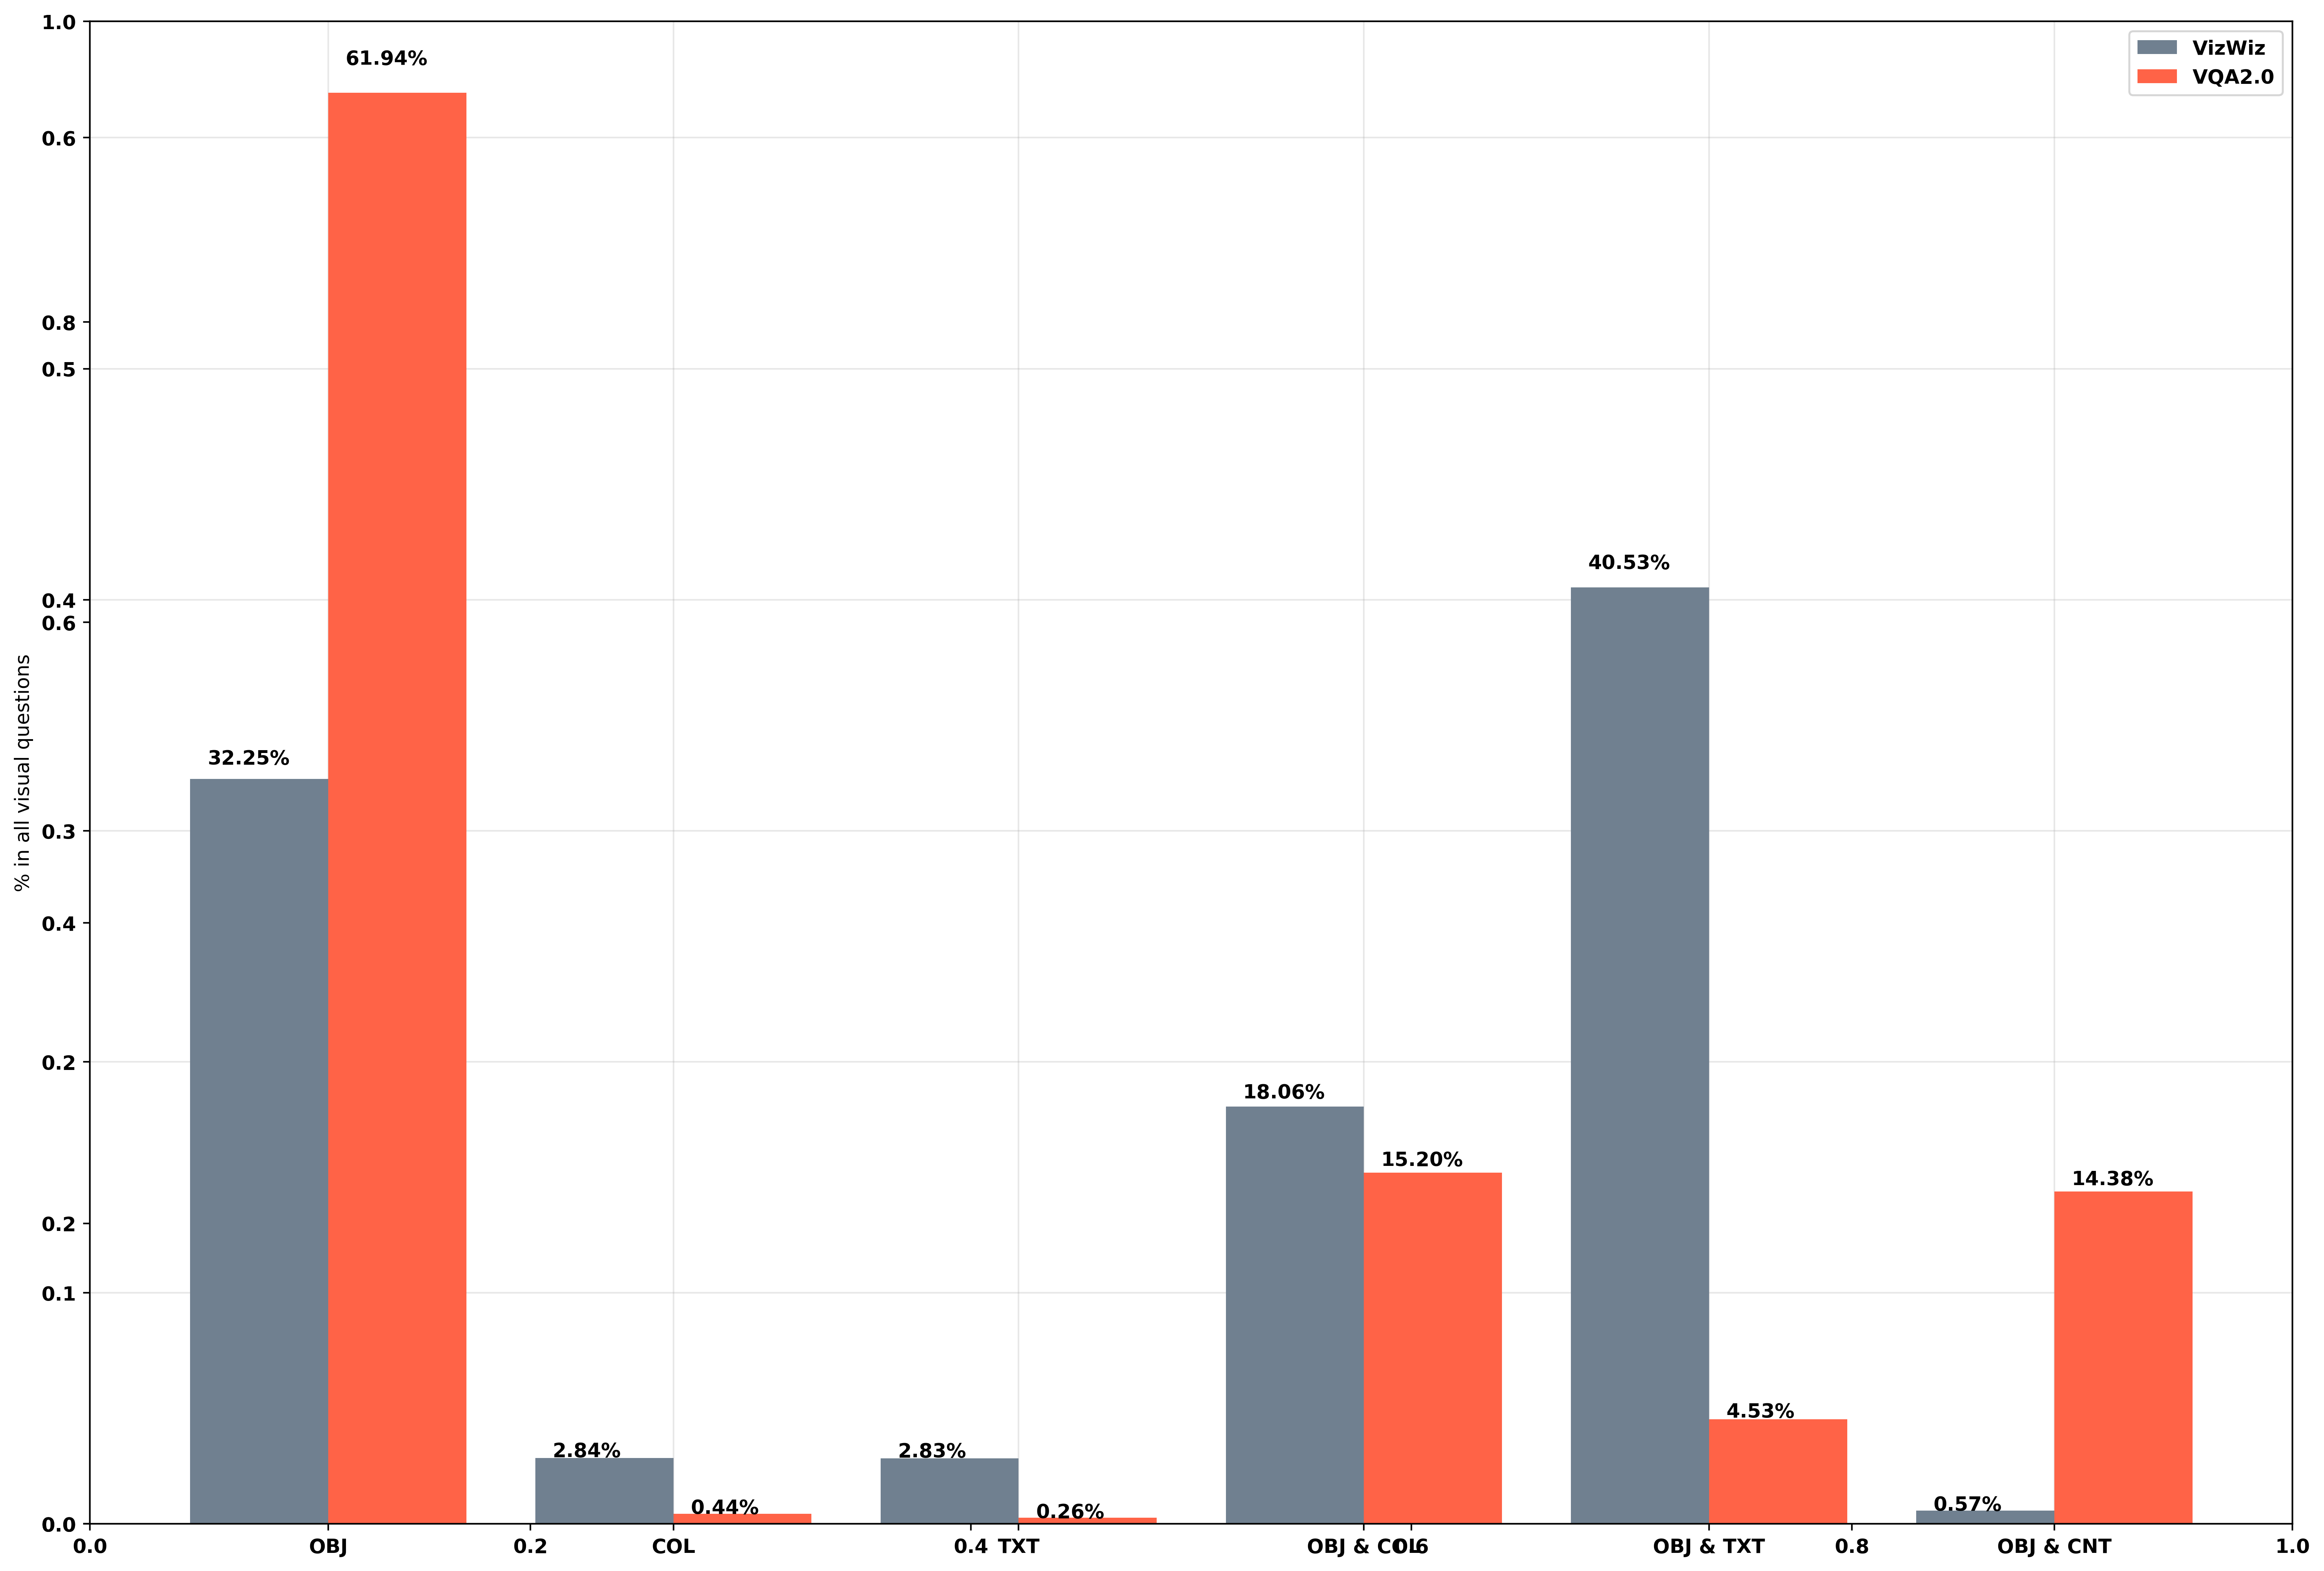

In [14]:
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["font.size"] = "12"
import matplotlib.ticker as mtick

fig, one_skill_plot = plt.subplots(figsize=(20, 14), dpi=400)

w = 0.4
itv = 0.2
skills = ['OBJ', 'COL', 'TXT', 
         'OBJ & COL', 'OBJ & TXT', 'OBJ & CNT']
_one_skill = np.arange(len(skills))

vizwiz_data = [one_skill(vizwiz, 'OBJ'), one_skill(vizwiz, 'COL'), one_skill(vizwiz, 'TXT'), 
               two_skills(vizwiz, 'OBJ', 'COL'), two_skills(vizwiz, 'OBJ', 'TXT'), two_skills(vizwiz, 'OBJ', 'CNT')]

vqa_data = [one_skill(vqa, 'OBJ'), one_skill(vqa, 'COL'), one_skill(vqa, 'TXT'), 
               two_skills(vqa, 'OBJ', 'COL'), two_skills(vqa, 'OBJ', 'TXT'), two_skills(vqa, 'OBJ', 'CNT')]

one_skill_plot = fig.add_subplot(1,1,1)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)

vizwiz_bars = one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategrey')
vqa_bars = one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')

# add percentages on top of each bar
for i, bar in enumerate(vizwiz_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vizwiz_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()+0.05), y=(1.02 * height),
                        s=percentage)
for i, bar in enumerate(vqa_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vqa_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()+0.05), y=(1.02 * height),
                        s=percentage)

one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = [i/10 for i in range(10)]
one_skill_plot.set_yticklabels(one_skill_plot_y_ticks)
# one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
one_skill_plot.legend()

plt.subplots_adjust(hspace=.3)
plt.show()

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764


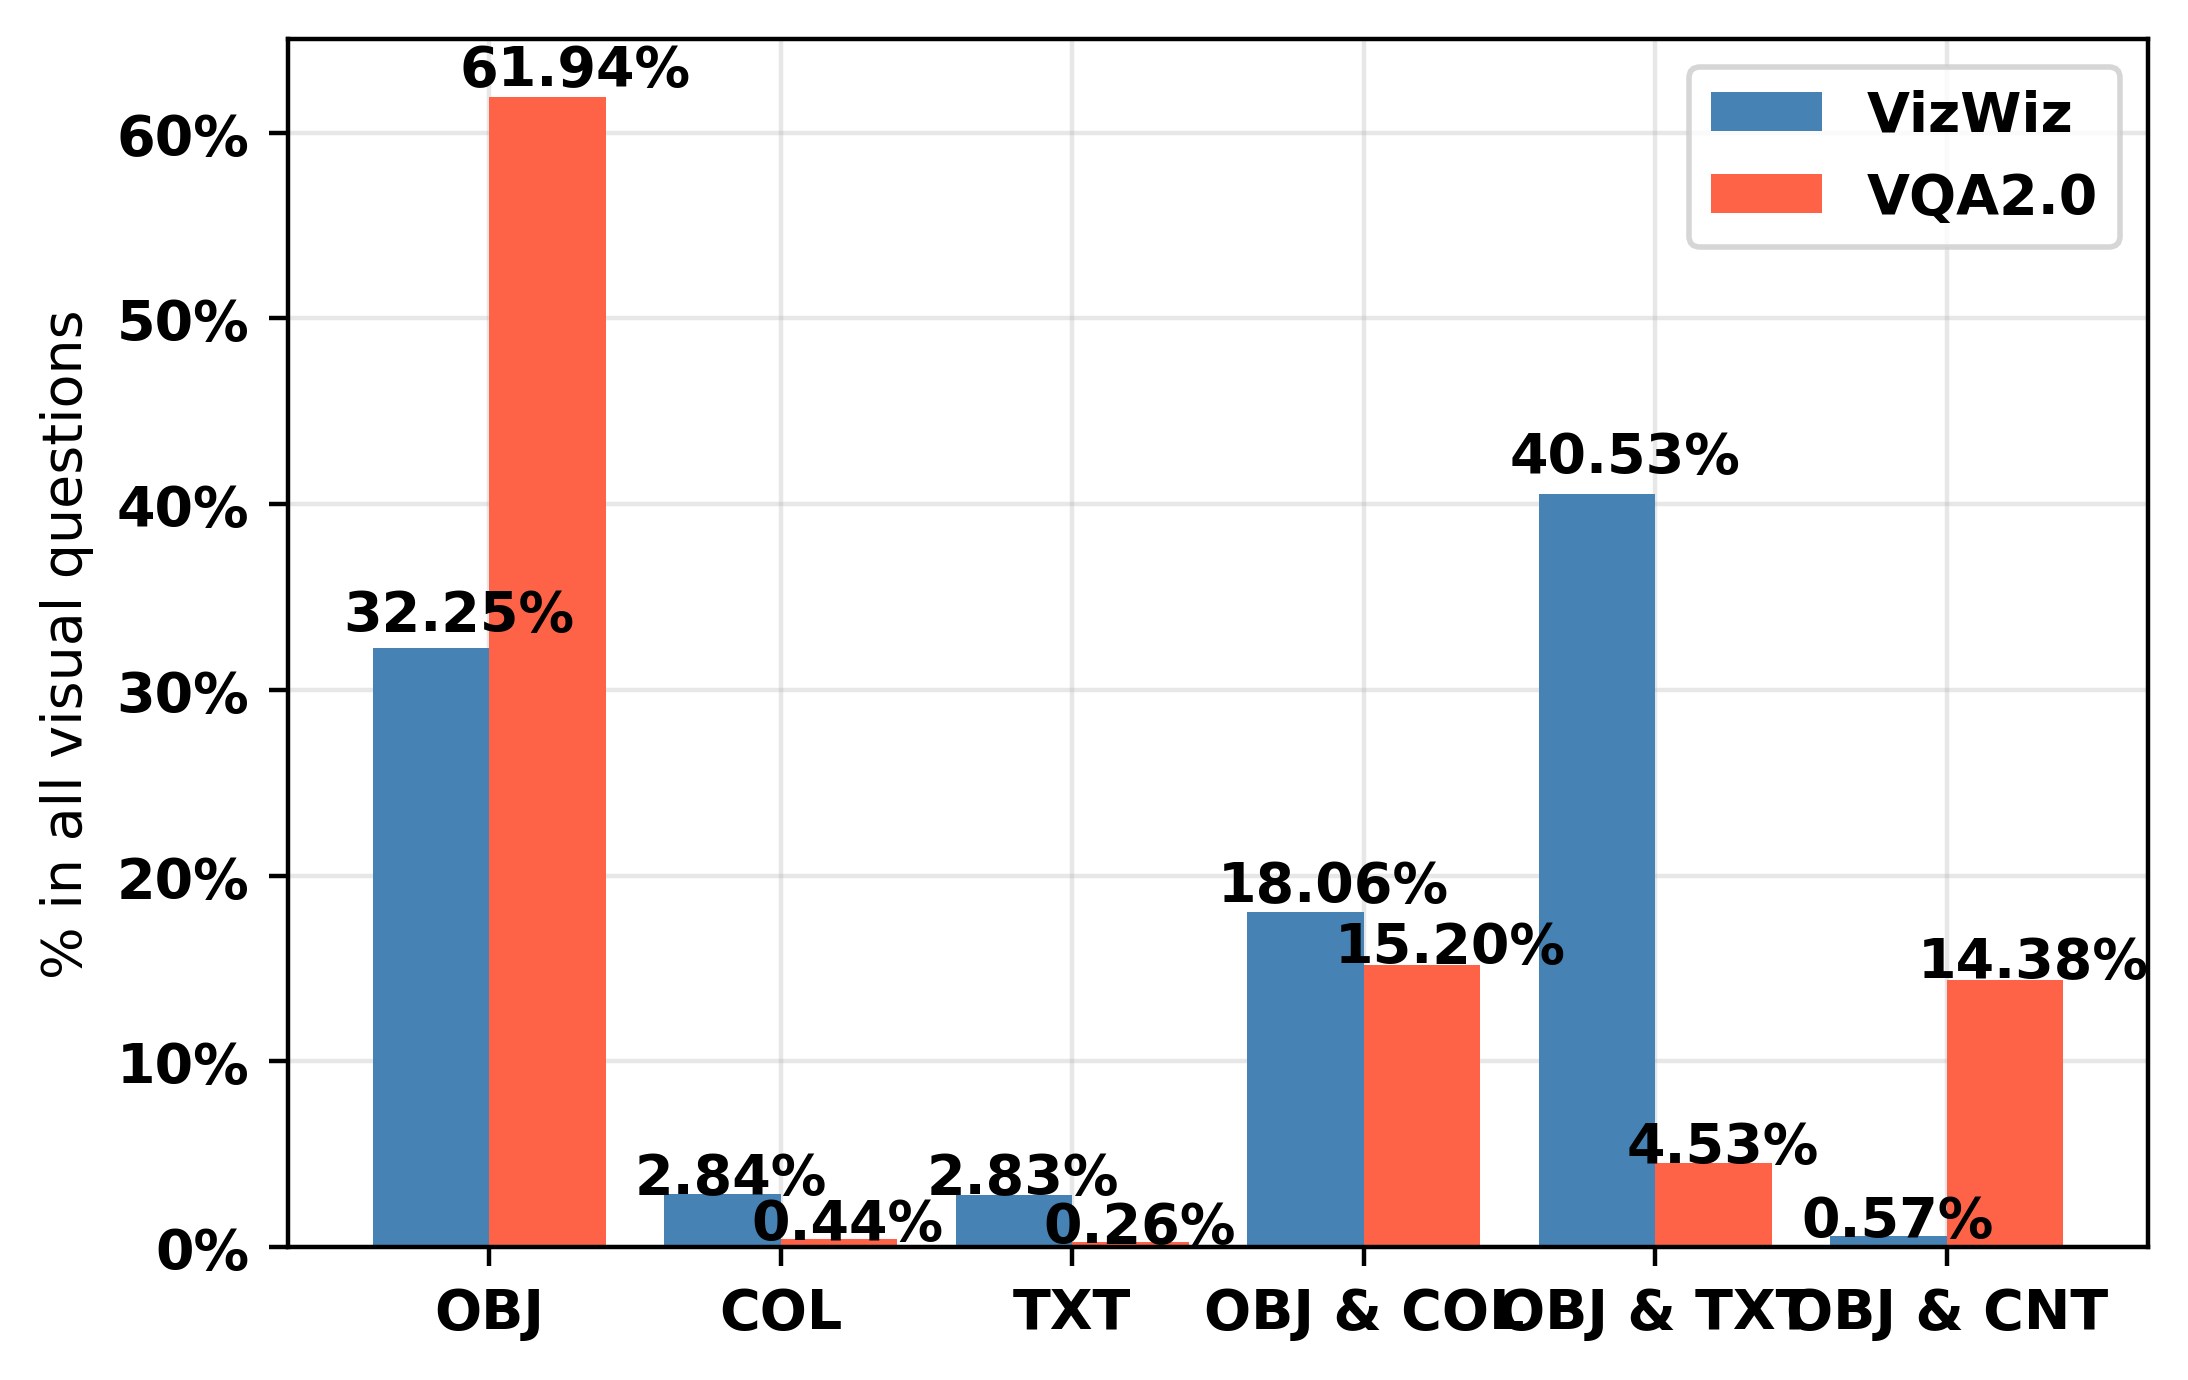

In [33]:
fig, one_skill_plot = plt.subplots(figsize=(6,4), dpi=400)

w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 
         'OBJ & COL', 'OBJ & TXT', 'OBJ & CNT']
_one_skill = np.arange(len(skills))

vizwiz_data = [one_skill(vizwiz, 'OBJ'), one_skill(vizwiz, 'COL'), one_skill(vizwiz, 'TXT'), 
               two_skills(vizwiz, 'OBJ', 'COL'), two_skills(vizwiz, 'OBJ', 'TXT'), two_skills(vizwiz, 'OBJ', 'CNT')]

vqa_data = [one_skill(vqa, 'OBJ'), one_skill(vqa, 'COL'), one_skill(vqa, 'TXT'), 
               two_skills(vqa, 'OBJ', 'COL'), two_skills(vqa, 'OBJ', 'TXT'), two_skills(vqa, 'OBJ', 'CNT')]

#one_skill_plot = fig.add_subplot(3,1,1, sharex=None, sharey=None)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
vizwiz_bars = one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='steelblue')
vqa_bars = one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')

# add percentages on top of each bar
for i, bar in enumerate(vizwiz_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vizwiz_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()-0.1), y=(1.03 * height),
                        s=percentage)
for i, bar in enumerate(vqa_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vqa_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()-0.1), y=(1.01 * height),
                        s=percentage)

# update y-coord labels
one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
one_skill_plot.legend()

plt.subplots_adjust(hspace=.3)
plt.show()

In [26]:
one_skill(vizwiz, 'COL') + one_skill(vizwiz, 'TXT') + one_skill(vizwiz, 'CNT')

COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737


0.05700530909745343

In [27]:
one_skill(vqa, 'COL') + one_skill(vqa, 'TXT') + one_skill(vqa, 'CNT')

COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482


0.011918951132300359

In [29]:
two_skills(vqa, 'COL', 'OBJ') + two_skills(vqa, 'TXT', 'OBJ') + two_skills(vqa, 'CNT', 'OBJ')

COL & OBJ: 0.15196662693682955
TXT & OBJ: 0.04529201430274136
CNT & OBJ: 0.14382201032975764


0.34108065156932854

In [8]:
vizwiz.loc[vizwiz['QSN'].str.startswith("Let's")]['QSN'].tolist()

["Let's try this again. What is in this can?",
 "Let's try this again.  I don't know if I did this right.  What is on the wrapper that I just took a picture of?  What is the",
 "Let's try it again. Can you tell me what the oven temperature is now? Thanks.",
 "Let's try this again. Is there an image on the monitor screen now?",
 "Let's try it again. What is this? Thanks so much.",
 "Let's give this a try, can you tell me what this is? ",
 "Let's try this again. This is a medication bottle. I just wanted to find out if their was a label and what the label is. Thank You. ",
 "Let's try one more time. What color is my pants? Thank you.",
 "Let's try one more time, what color is my pants? "]

OBJ: 0.32246018176909924
COL: 0.028435166021776297
TXT: 0.02830018896787546
OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427
OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764


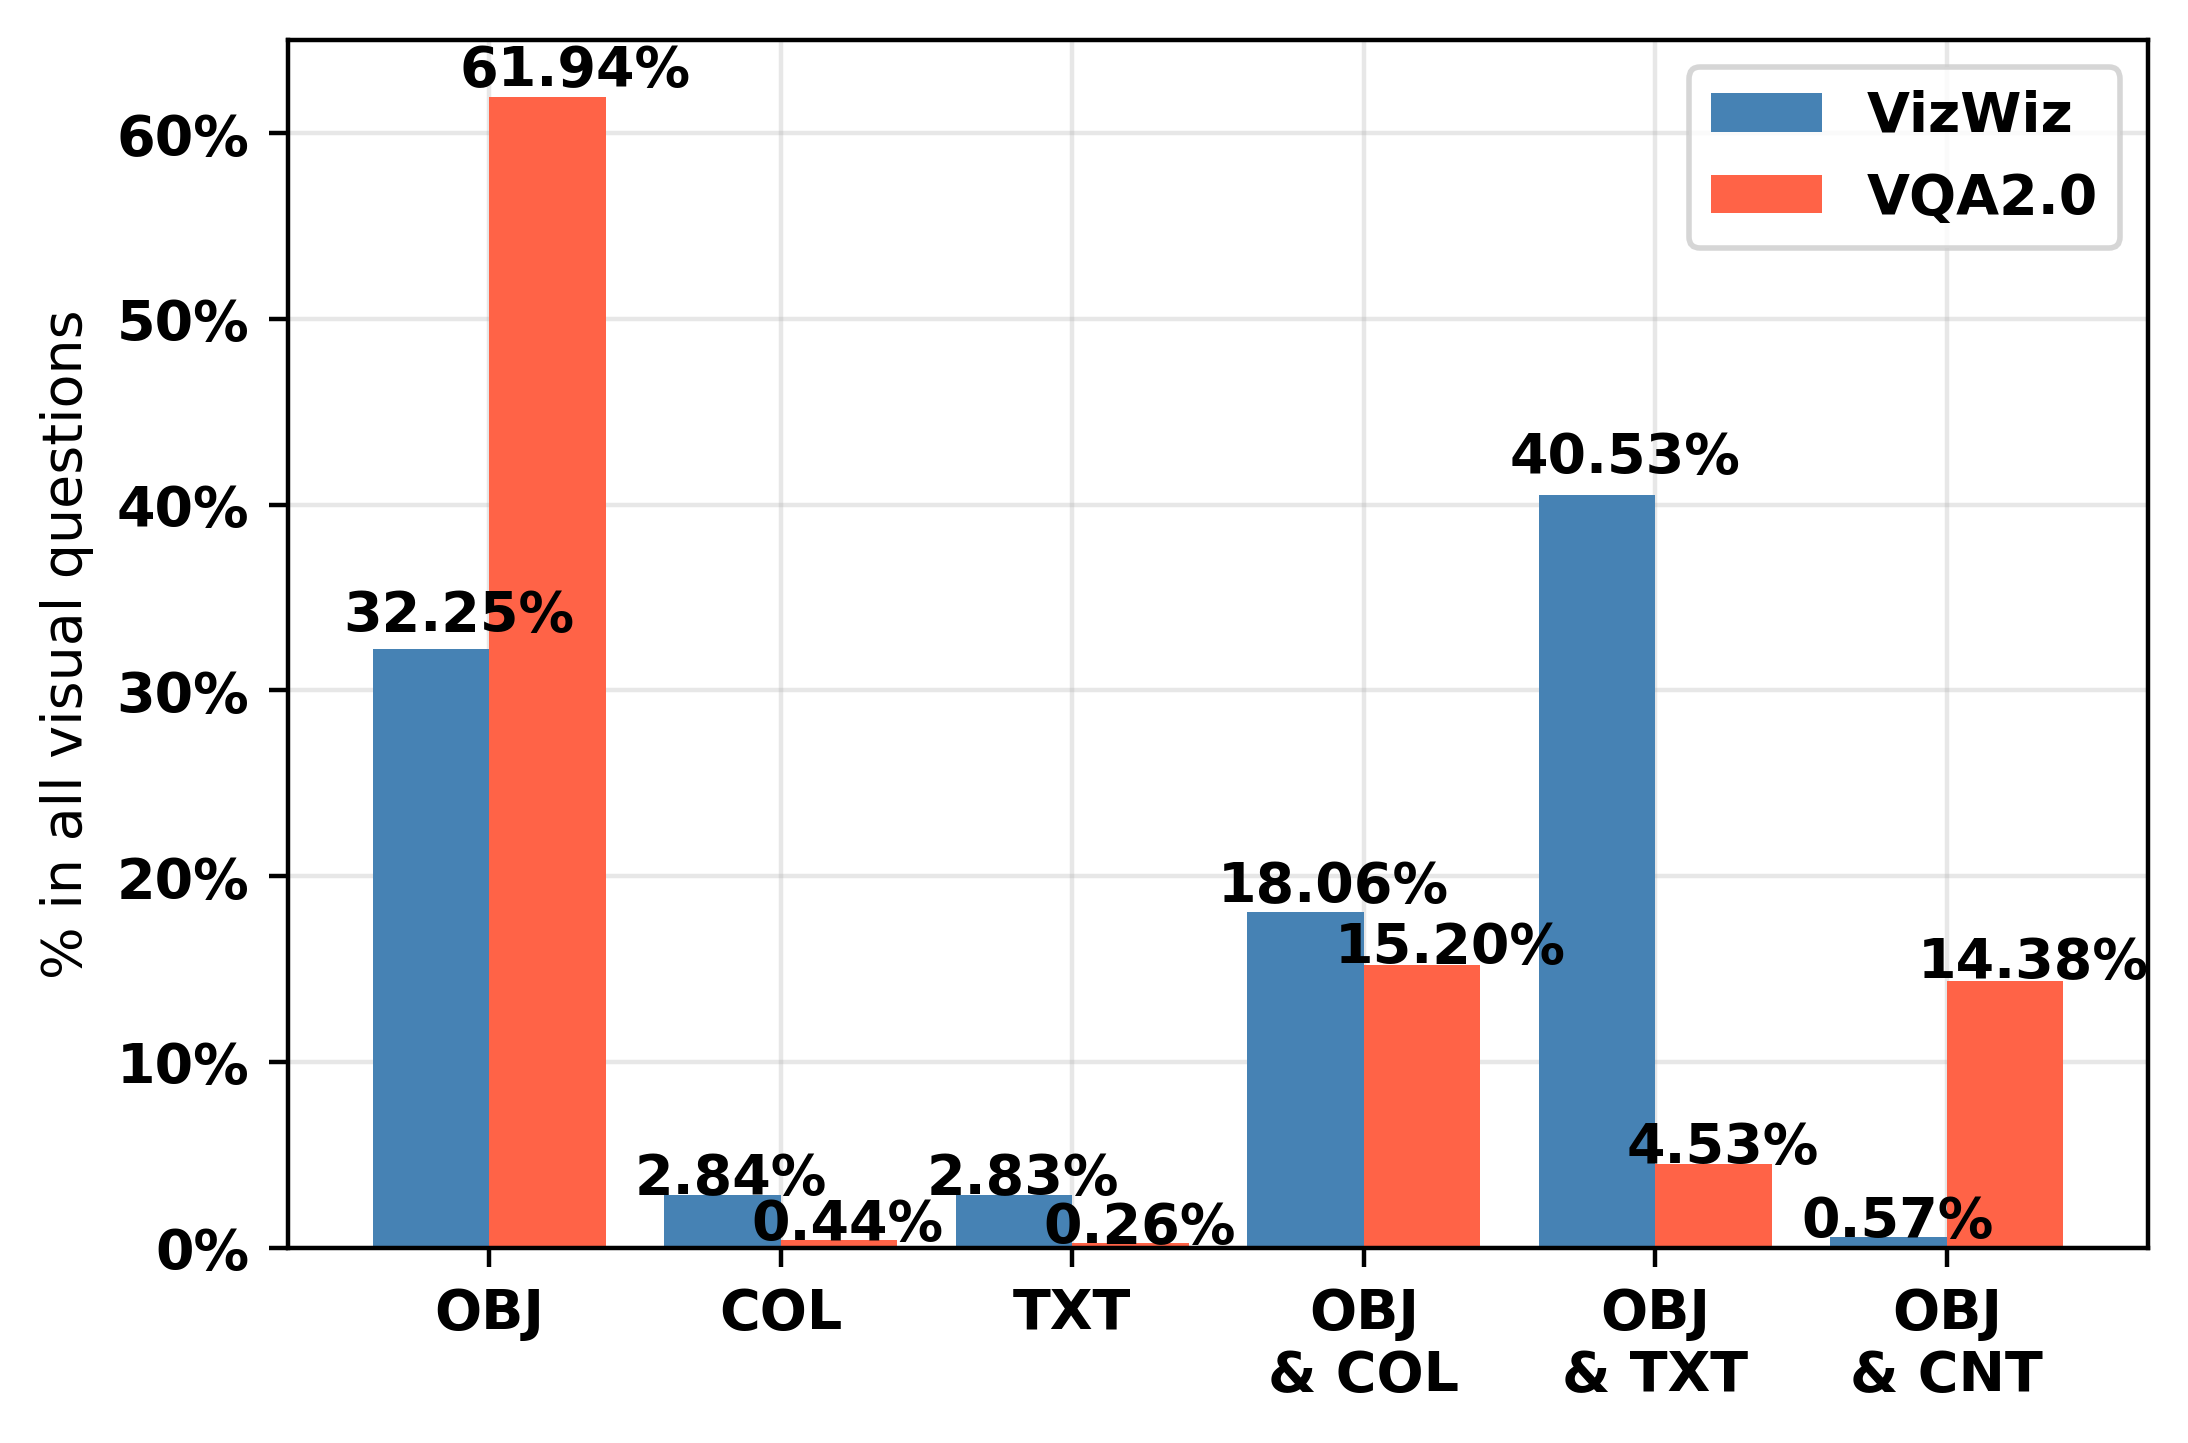

In [24]:
fig, one_skill_plot = plt.subplots(figsize=(6,4), dpi=400)

w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 
         'OBJ\n& COL', 'OBJ\n& TXT', 'OBJ\n& CNT']
_one_skill = np.arange(len(skills))

vizwiz_data = [one_skill(vizwiz, 'OBJ'), one_skill(vizwiz, 'COL'), one_skill(vizwiz, 'TXT'), 
               two_skills(vizwiz, 'OBJ', 'COL'), two_skills(vizwiz, 'OBJ', 'TXT'), two_skills(vizwiz, 'OBJ', 'CNT')]

vqa_data = [one_skill(vqa, 'OBJ'), one_skill(vqa, 'COL'), one_skill(vqa, 'TXT'), 
               two_skills(vqa, 'OBJ', 'COL'), two_skills(vqa, 'OBJ', 'TXT'), two_skills(vqa, 'OBJ', 'CNT')]


one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
vizwiz_bars = one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='steelblue')
vqa_bars = one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')

# add percentages on top of each bar
for i, bar in enumerate(vizwiz_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vizwiz_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()-0.1), y=(1.03 * height),
                        s=percentage)
for i, bar in enumerate(vqa_bars):
    height = bar.get_height()
    percentage = "%.2f" % (vqa_data[i] * 100) + '%'
    one_skill_plot.text(x=(bar.get_x()-0.1), y=(1.01 * height),
                        s=percentage)


# update y-coord labels
one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
one_skill_plot.legend()

#plt.xticks(rotation=90)
plt.subplots_adjust(hspace=.3)

plt.show()

In [28]:
dset = vizwiz
two_skills(dset, "OBJ", "COL") + two_skills(dset, "OBJ", "TXT") + two_skills(dset, "OBJ", "CNT")

OBJ & COL: 0.18064429047062
OBJ & TXT: 0.4052911005129128
OBJ & CNT: 0.005714028615135427


0.5916494195986682

In [7]:
dset = vqa
two_skills(dset, "OBJ", "COL") + two_skills(dset, "OBJ", "TXT") + two_skills(dset, "OBJ", "CNT")

OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764


0.34108065156932854

In [5]:
dset = vizwiz
one_skill(dset, "COL") + one_skill(dset, "TXT") + one_skill(dset, "CNT")

COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737


0.05700530909745343

In [6]:
dset = vqa
one_skill(dset, "COL") + one_skill(dset, "TXT") + one_skill(dset, "CNT")

COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482


0.011918951132300359

In [22]:
dset = vizwiz
three_skills(dset, "OBJ", "COL", "TXT") + three_skills(dset, 'OBJ', 'COL', 'CNT') + three_skills(dset, 'OBJ', "TXT", 'CNT') + two_skills(dset, 'COL', 'TXT') + two_skills(dset, 'COL', "CNT") + two_skills(dset, 'TXT', 'CNT')

OBJ & COL & TXT: 0.01070817960946639
OBJ & COL & CNT: 0.0003599388104022316
OBJ & TXT & CNT: 0.007153783856744354
COL & TXT: 0.00040493116170251057
COL & CNT: 0.0
TXT & CNT: 0.0013047781877080897


0.019931611626023575

In [19]:
dset = vqa
two_skill_nonexclusive(dset, 'COL', 'TXT') + two_skill_nonexclusive(dset, 'COL', 'CNT') + two_skill_nonexclusive(dset, 'TXT', 'CNT')

COL & TXT: 0.0013905442987683751
COL & CNT: 0.009137862534763607
TXT & CNT: 0.0077473182359952325


0.018275725069527213

In [25]:
dset = vizwiz
one_skill(dset, 'CNT')

CNT: 0.0002699541078016737


0.0002699541078016737

In [39]:
vizwiz.loc[vizwiz['IMG'] == 'VizWiz_train_000000001834.jpg']['QSN']

1295    Does that look clean? Thank you.
Name: QSN, dtype: object